This notebook consists of the PPO and uncertainty quantification of all five sampling methods, both the identifiable and the non-identifiable variations. 

In [1]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import sys
import pymc3 as pm
import arviz as az
import seaborn as sns
import pickle
# from pymc3.theanof import MRG_RandomStreams, set_tt_rng
import theano.tensor as tt
from tqdm import tqdm
from numpy.random import default_rng
import time
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs
from utils.BNN_pymc3 import BNN_LV as BNN_LV_pymc3
from utils.custom_callbacks_pymc3 import plot95ci, wb_scatter, build_wb_callback
from utils.decomposition import lunar_entropy_decompose
from utils.calculations import PPO

In [4]:
%config InlineBackend.figure_format = 'retina'

np.set_printoptions(precision=3, suppress=True)
RANDOM_SEED = 31430
rng = default_rng(RANDOM_SEED)

In [5]:
from utils.games import LunarLander2D

### Set up simulation and extract data

In [6]:
env = LunarLander2D(L=4, W=5, max_steps=20, seed=207)
no_action_policy = lambda state: (0,0)  # For any state, play the "do nothing" action.
random_policy = None  # If the policy is None, the simulator chooses an action at random.

# choose to run on the no-action policy
env.run(episodes=100, progress=100, policy=no_action_policy)

Episode 100/100 took 20 steps.


In [7]:
transitions = env.extract_transition_dataset()
transitions = transitions.sample(frac=1, replace=False, random_state=123)
transitions

start_x  start_y  action_x  action_y  result_x  result_y
1031        4        3         0         0         4         2
320         3        0         0         0         3         0
1445        5        0         0         0         5         0
260         1        4         0         0         1         4
1308        5        0         0         0         5         0
...       ...      ...       ...       ...       ...       ...
1122        3        0         0         0         3         0
1346        2        0         0         0         2         0
1406        4        0         0         0         4         0
1389        5        0         0         0         5         0
1534        5        0         0         0         5         0

[1598 rows x 6 columns]

In [8]:
# Build training data (ignore X dimension and try to use starting Y position and Y action to predict landing Y position):
X_train = transitions[['start_x','start_y','action_x','action_y']].to_numpy()
Y_train = transitions[['result_x','result_y']].to_numpy()

print('X :',X_train.shape)
print('Y :',Y_train.shape)


X : (1598, 4)
Y : (1598, 2)


### Setup BNN_LV architecture and perform MLE fit

In [9]:
# Parameters
gamma = 2 
sigma = 1

architecture = {'input_n':4, 
             'output_n':2, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma],
             'sigma':[sigma,sigma]}

bnn_lv_lunar = BNN_LV_pymc3(architecture=architecture, seed=1)

bnn_lv_lunar.fit(X_train, Y_train, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 2646.096337433959; gradient mag: 6061.788603341931
Iteration 500 lower bound 0.22921482692358316; gradient mag: 0.701654750765489
Iteration 1000 lower bound 0.16745112375411556; gradient mag: 0.3678438077869452
Iteration 1500 lower bound 0.13787118880350424; gradient mag: 0.1974624817857982
Iteration 2000 lower bound 0.11687353213758936; gradient mag: 0.1297895781285146
Iteration 2500 lower bound 0.10243598328524456; gradient mag: 0.08147604806238404
Iteration 3000 lower bound 0.09403996953491084; gradient mag: 0.06523531391007817
Iteration 3500 lower bound 0.08969548468738456; gradient mag: 0.06261075664616812
Iteration 4000 lower bound 0.08731744799811035; gradient mag: 0.08022712256963357
Iteration 4500 lower bound 0.08465591981245585; gradient mag: 0.2514360889520257


## Loading necessary data

### Gathering all posterior samples

In [10]:
# Metropolis
post_met = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3MET.npy')
post_metn = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3MET-2.npy')

In [11]:
# HMC
post_hmc = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3HMC.npy')
post_hmcn = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3HMC-2.npy')

In [12]:
# NUTS
post_nuts = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3NUTS.npy')
post_nutsn = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3NUTS-2.npy')

In [10]:
# ADVI
post_advi = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3ADVI.npy')
post_advin = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3ADVI-2.npy')

In [11]:
# SVGD
post_svgd = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3SVGD.npy')
post_svgdn = np.load('./training/d4rl-atari/saved_samples/lunar_samples_pymc3SVGD-2.npy')

### Gathering all inference data

In [15]:
# Metropolis
idata_met = az.from_netcdf('./training/idata_Lmet.nc')
idata_metn = az.from_netcdf('./training/idata_Lmet_uni.nc')

In [15]:
# HMC
idata_hmc = az.from_netcdf('./training/idata_Lphmc.nc')
idata_hmcn = az.from_netcdf('./training/idata_Lphmc_uni.nc')

In [16]:
# NUTS
idata_nuts = az.from_netcdf('./training/idata_Lnuts.nc')
idata_nutsn = az.from_netcdf('./training/idata_Lnuts_uni.nc')

In [12]:
# ADVI
idata_advi = az.from_netcdf('./training/idata_Ladvi.nc')
idata_advin = az.from_netcdf('./training/idata_Ladvi_uni.nc')

In [13]:
# SVGD
idata_svgd = az.from_netcdf('./training/idata_Lsvgd.nc')
idata_svgdn = az.from_netcdf('./training/idata_Lsvgd_uni.nc')

### Gathering all traces

In [20]:
# Metropolis
with open('./training/trace_Lmet.p', 'rb') as f:
    trace_met = pickle.load(f)
    
with open('./training/trace_Lmet_uni.p', 'rb') as g:
    trace_metn = pickle.load(g)

In [19]:
# HMC
with open('./training/trace_Lphmc.p', 'rb') as f:
    trace_hmc = pickle.load(f)
    
with open('./training/trace_Lphmc_uni.p', 'rb') as f:
    trace_hmcn = pickle.load(f)

In [20]:
# NUTS
with open('./training/trace_Lnuts.p', 'rb') as f:
    trace_nuts = pickle.load(f)
    
with open('./training/trace_Lnuts_uni.p', 'rb') as f:
    trace_nutsn = pickle.load(f)

In [14]:
# ADVI
with open('./training/trace_Ladvi.p', 'rb') as f:
    trace_advi = pickle.load(f)
    
with open('./training/trace_Ladvi_uni.p', 'rb') as f:
    trace_advin = pickle.load(f)

In [15]:
# SVGD
with open('./training/trace_Lsvgd.p', 'rb') as f:
    trace_svgd = pickle.load(f)
    
with open('./training/trace_Lsvgd_uni.p', 'rb') as f:
    trace_svgdn = pickle.load(f)

### Gathering all models

In [25]:
# Metropolis
with open('./training/model_Lmet.p', 'rb') as g:
    model_met = pickle.load(g)
    
with open('./training/model_Lmet_uni.p', 'rb') as g:
    model_metn = pickle.load(g)

In [23]:
# HMC
with open('./training/model_Lphmc.p', 'rb') as g:
    model_hmc = pickle.load(g)

with open('./training/model_Lphmc_uni.p', 'rb') as g:
    model_hmcn = pickle.load(g)

In [24]:
# NUTS
with open('./training/model_Lnuts.p', 'rb') as g:
    model_nuts = pickle.load(g)

with open('./training/model_Lnuts_uni.p', 'rb') as g:
    model_nutsn = pickle.load(g)

In [16]:
# ADVI
with open('./training/model_Ladvi.p', 'rb') as g:
    model_advi = pickle.load(g)
    
with open('./training/model_Ladvi_uni.p', 'rb') as g:
    model_advin = pickle.load(g)

In [17]:
# SVGD
with open('./training/model_Lsvgd.p', 'rb') as g:
    model_svgd = pickle.load(g)

with open('./training/model_Lsvgd_uni.p', 'rb') as g:
    model_svgdn = pickle.load(g)

## Method 1: Metropolis

### Identifiable Metropolis

#### Prior-Posterior Overlap

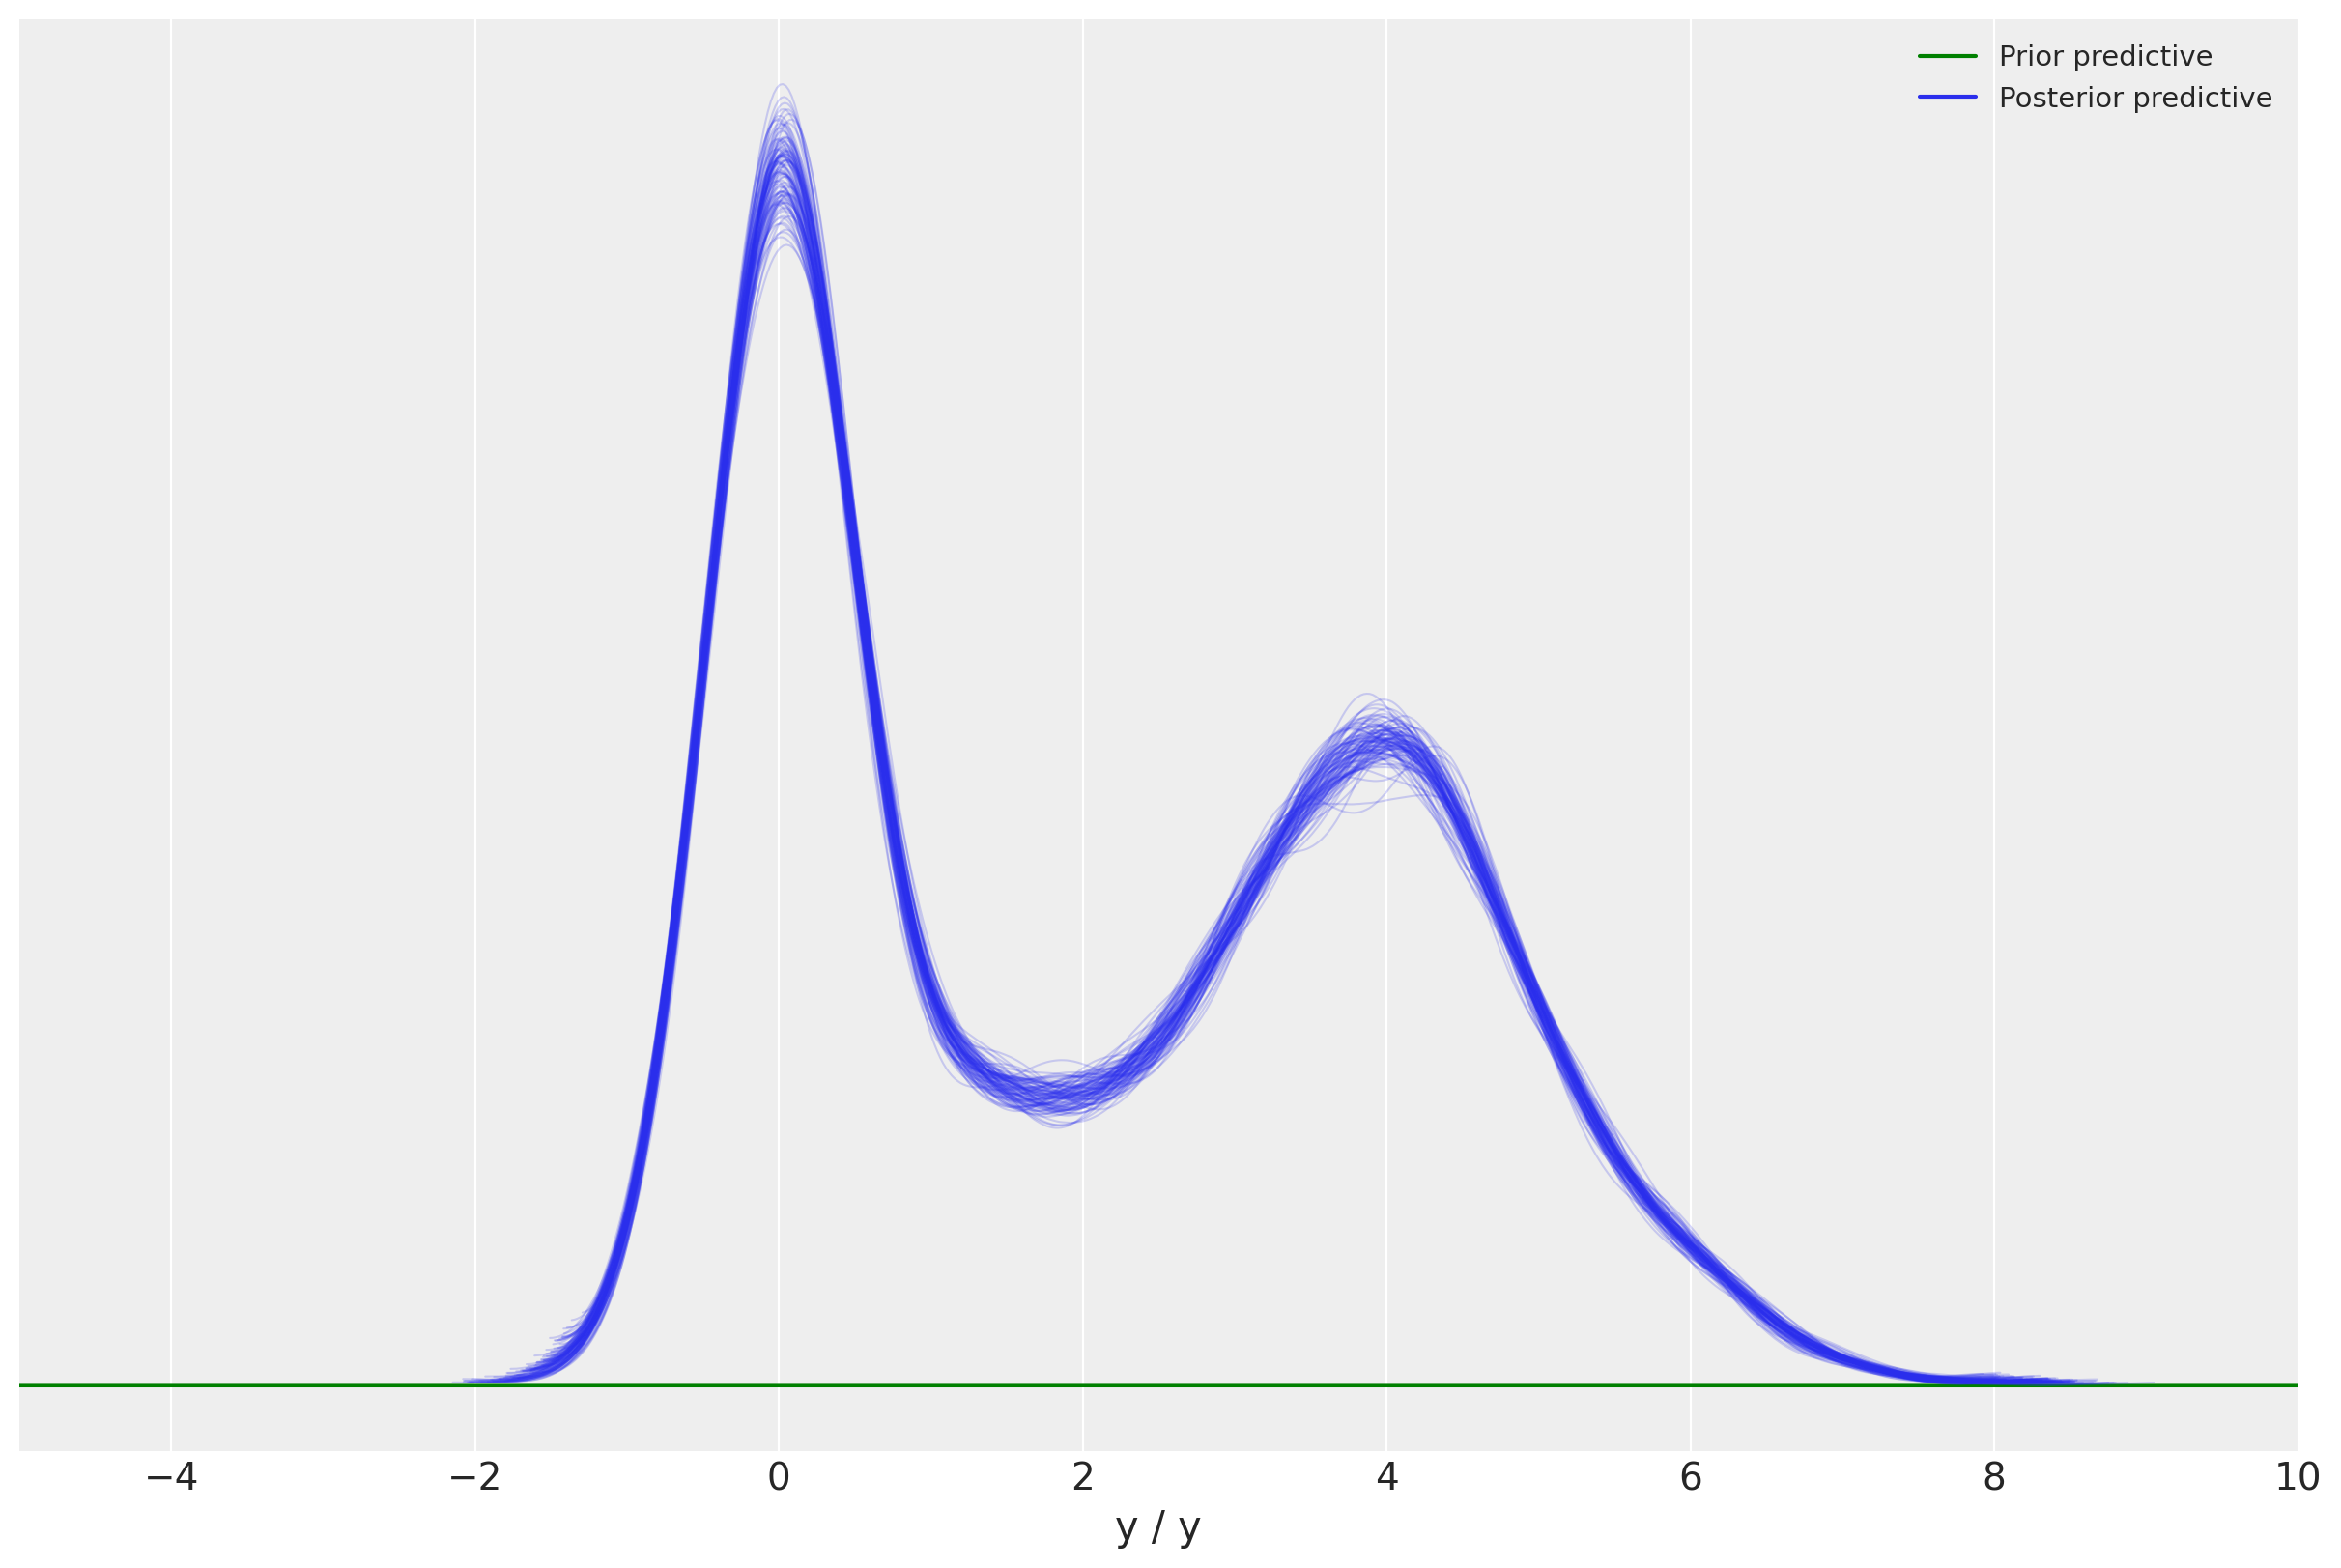

In [30]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_met, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_met, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lmet.png', dpi=300)
plt.show()

In [31]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_met.observed_data 
priorpredictive_dataset = idata_met.prior_predictive 
postpredictive_dataset = idata_met.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [54:02<00:00, 32.43s/it]


0.037702127659574466

#### Uncertainty Quantification

In [32]:
post_met.shape

(80000, 1, 582)

In [33]:
#thinning by factor of 32
post_met = post_met[::32, :]
post_met.shape

(2500, 1, 582)

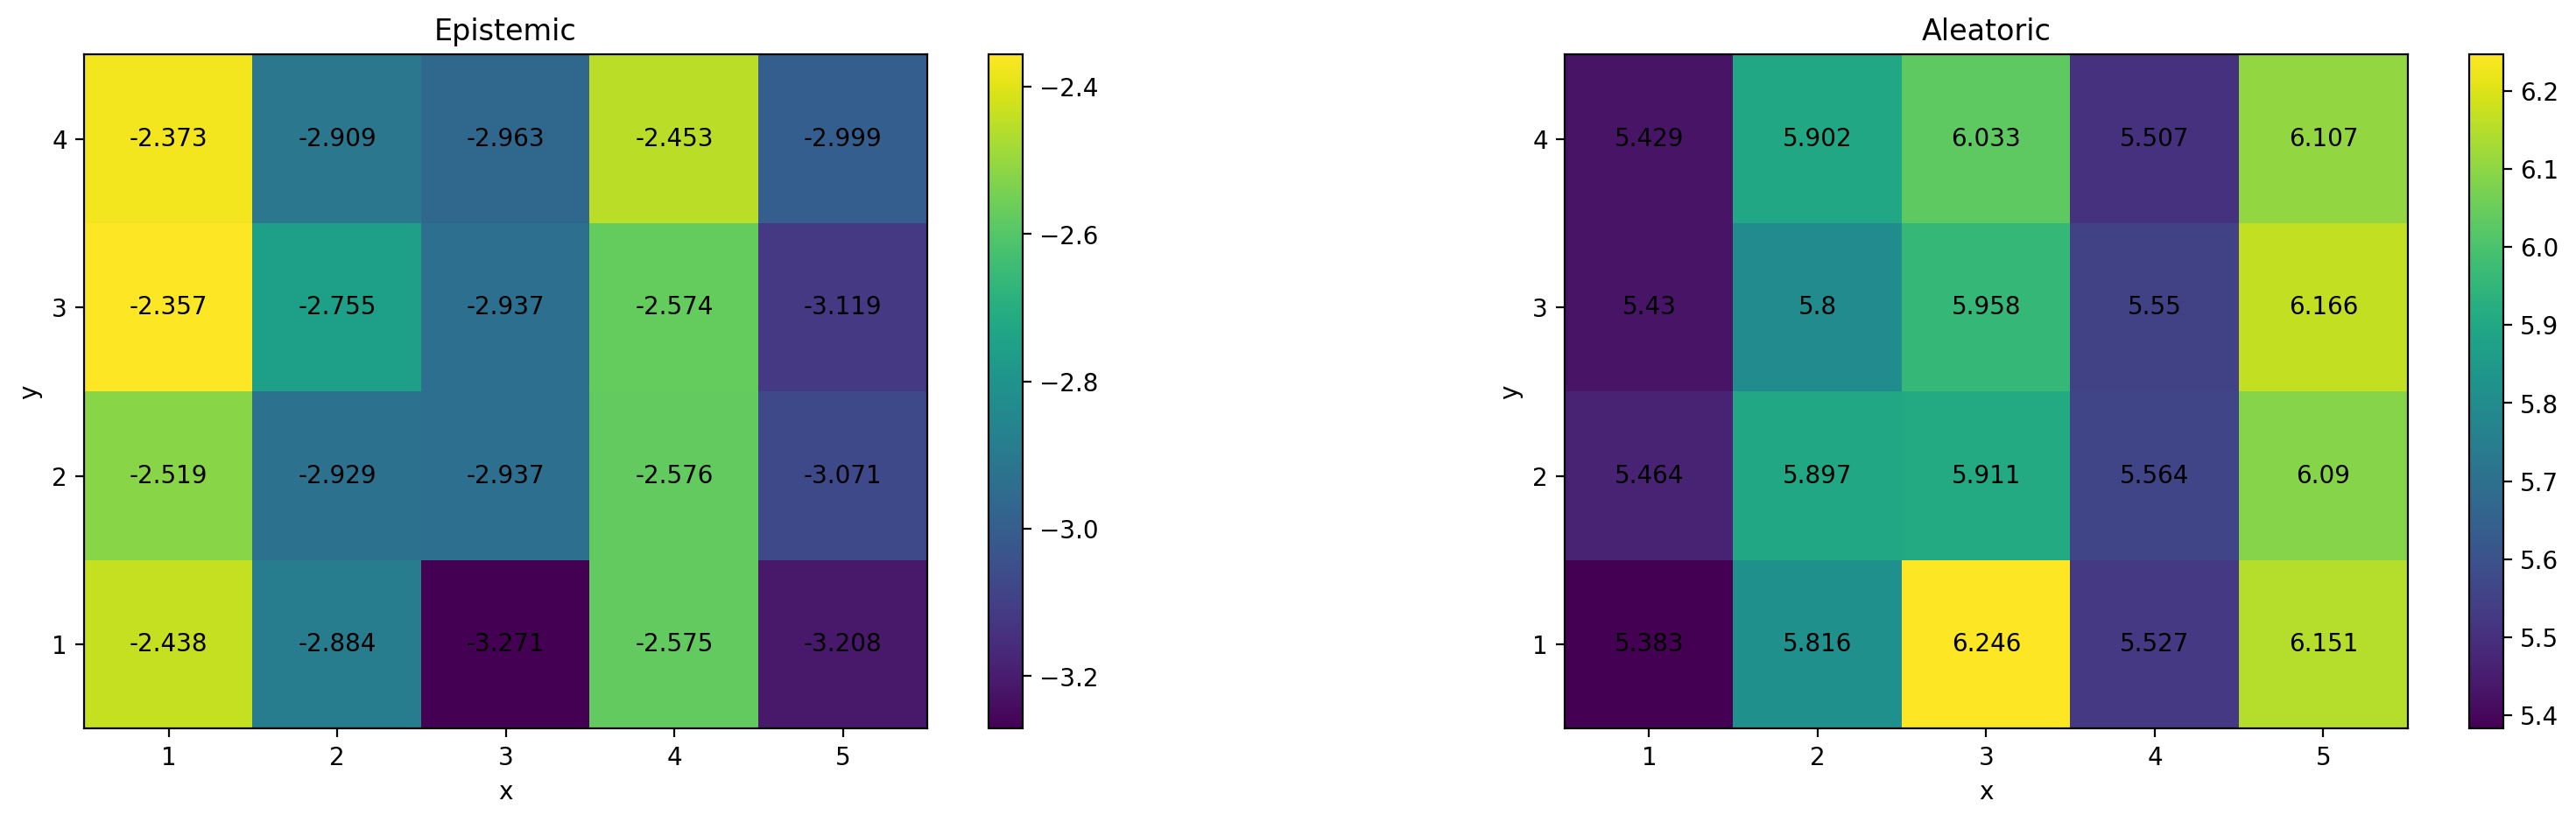

In [34]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_met, 
                                                N, N2, L, 'UQ_Lmet.png')

In [35]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_met.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_met.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

11882.884

### Non-identifiable Metropolis

#### Prior-Posterior Overlap

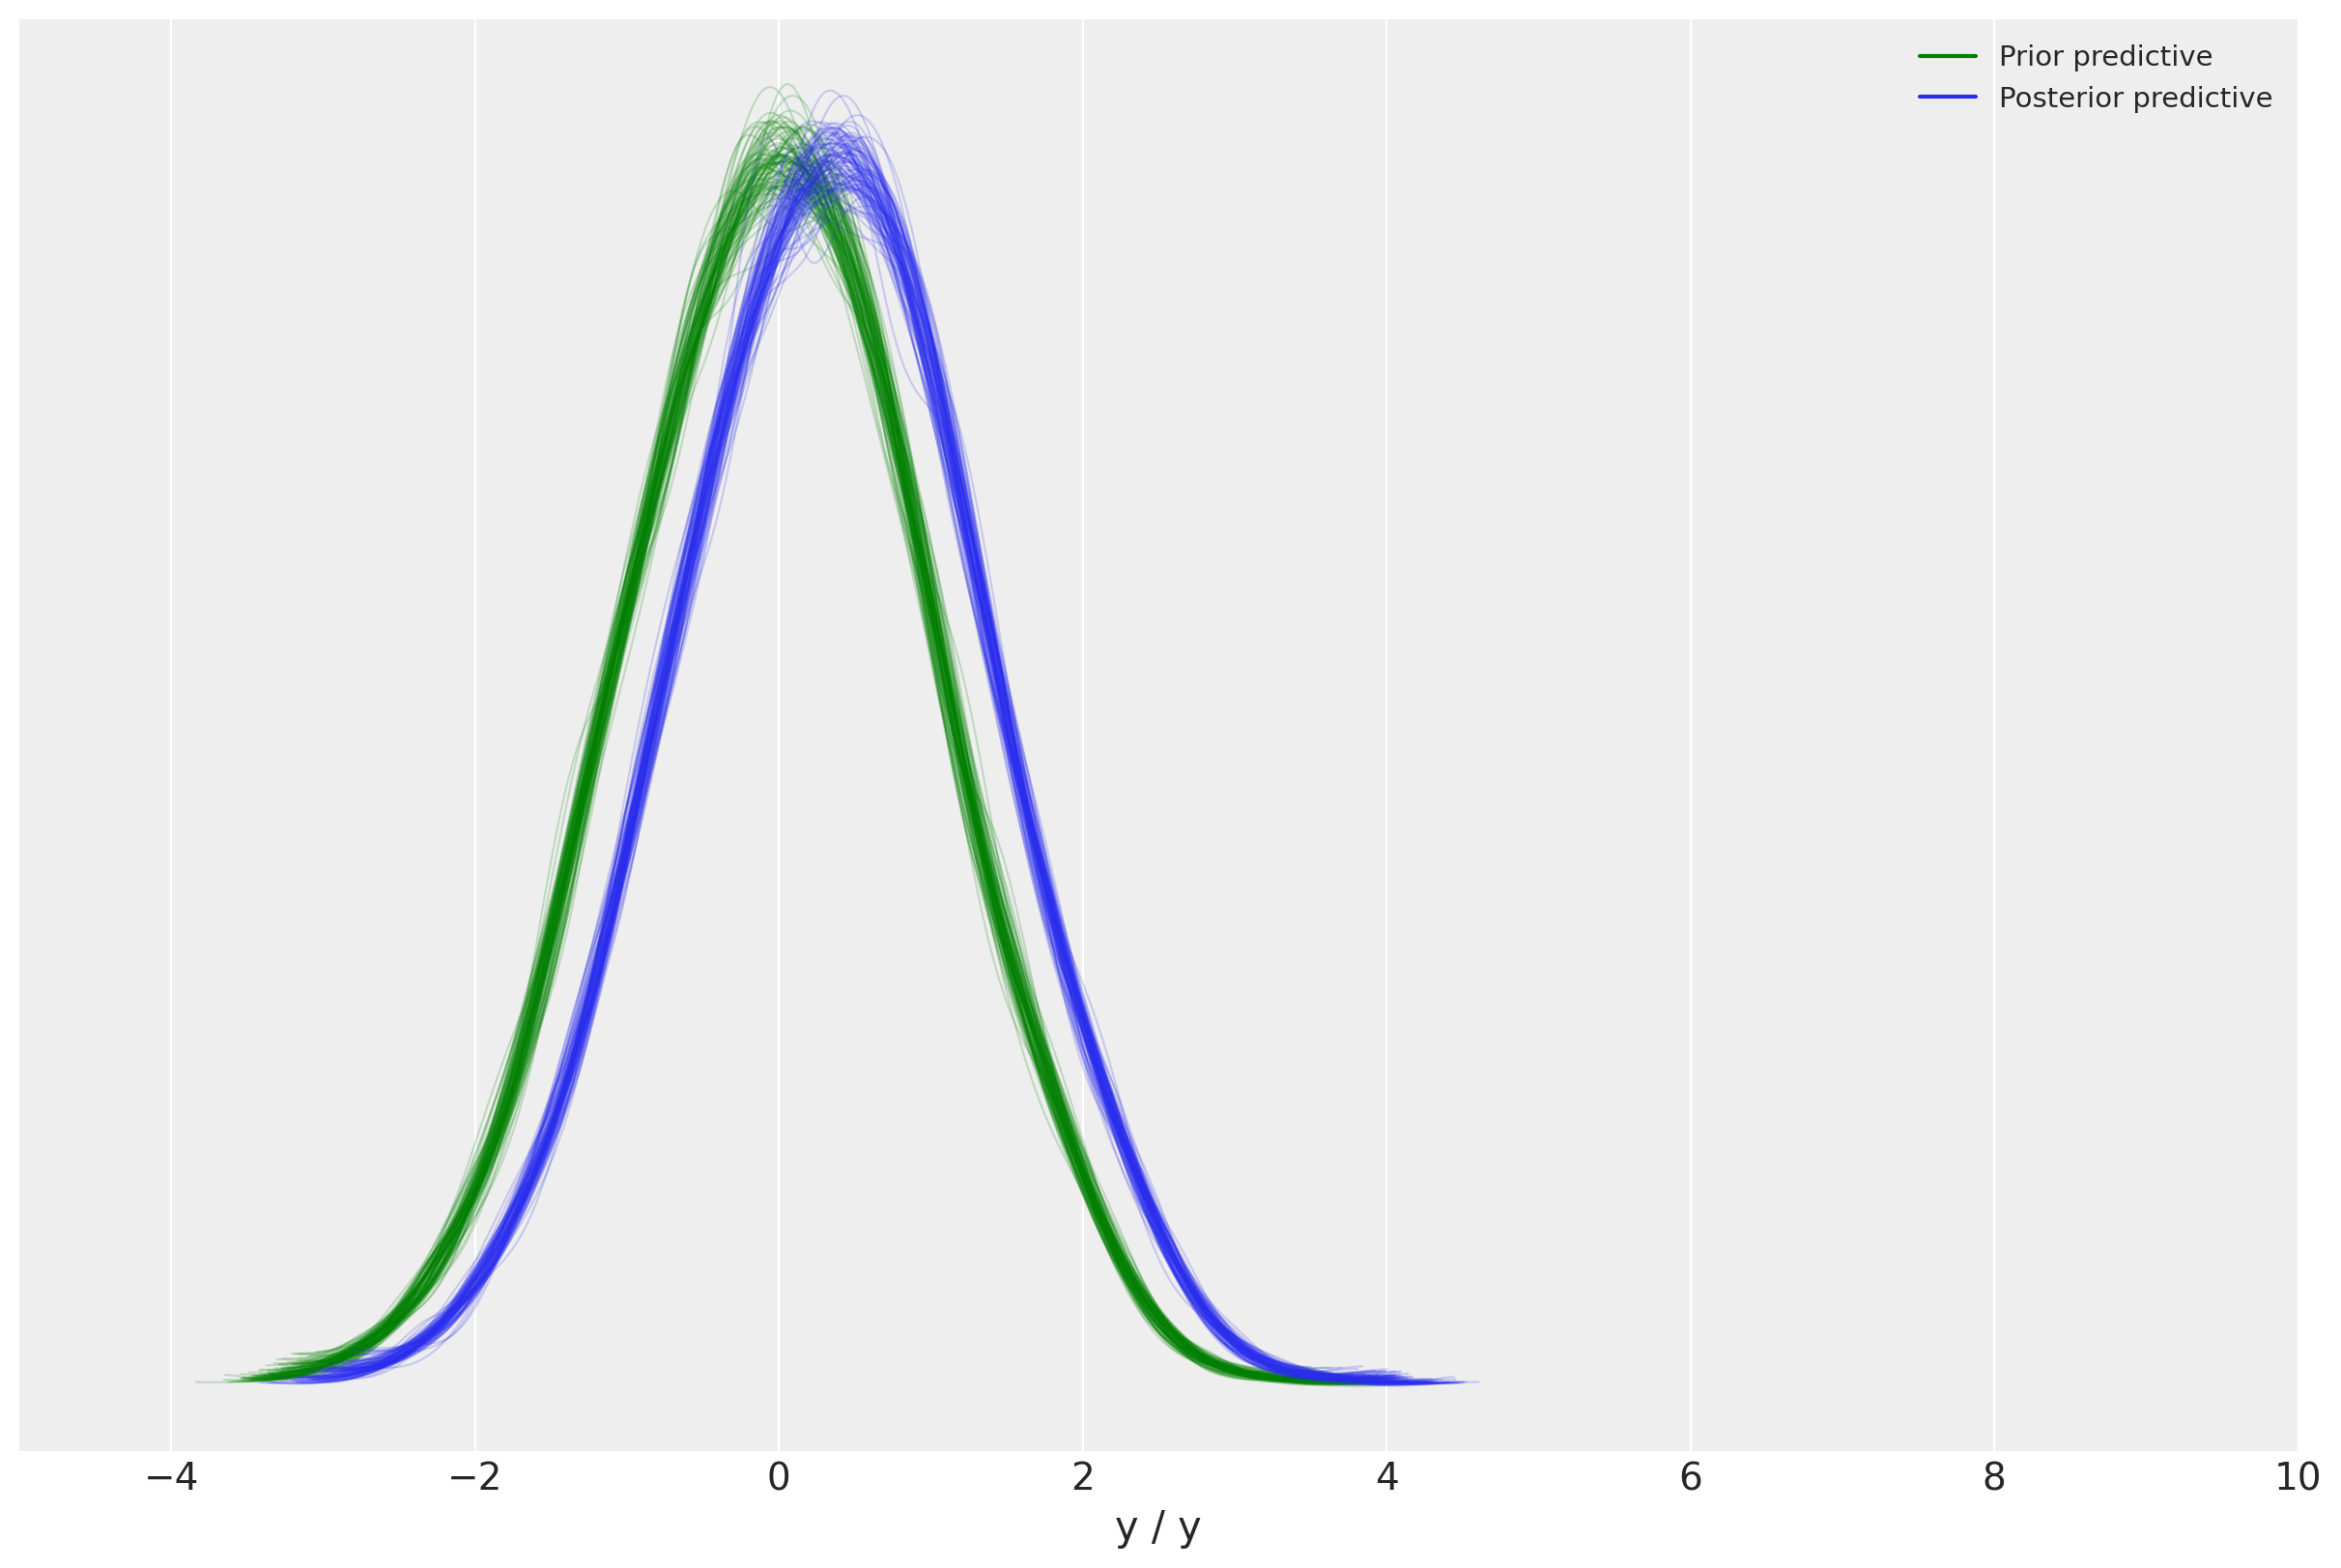

In [36]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_metn, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_metn, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lmet_uni.png', dpi=300)
plt.show()

In [37]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_metn.observed_data 
priorpredictive_dataset = idata_metn.prior_predictive 
postpredictive_dataset = idata_metn.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [1:15:46<00:00, 45.46s/it]


0.8663890488110138

#### Uncertainty Quantification

In [38]:
post_metn.shape

(80000, 1, 582)

In [39]:
#thinning by factor of 32
post_metn = post_metn[::32, :]
post_metn.shape

(2500, 1, 582)

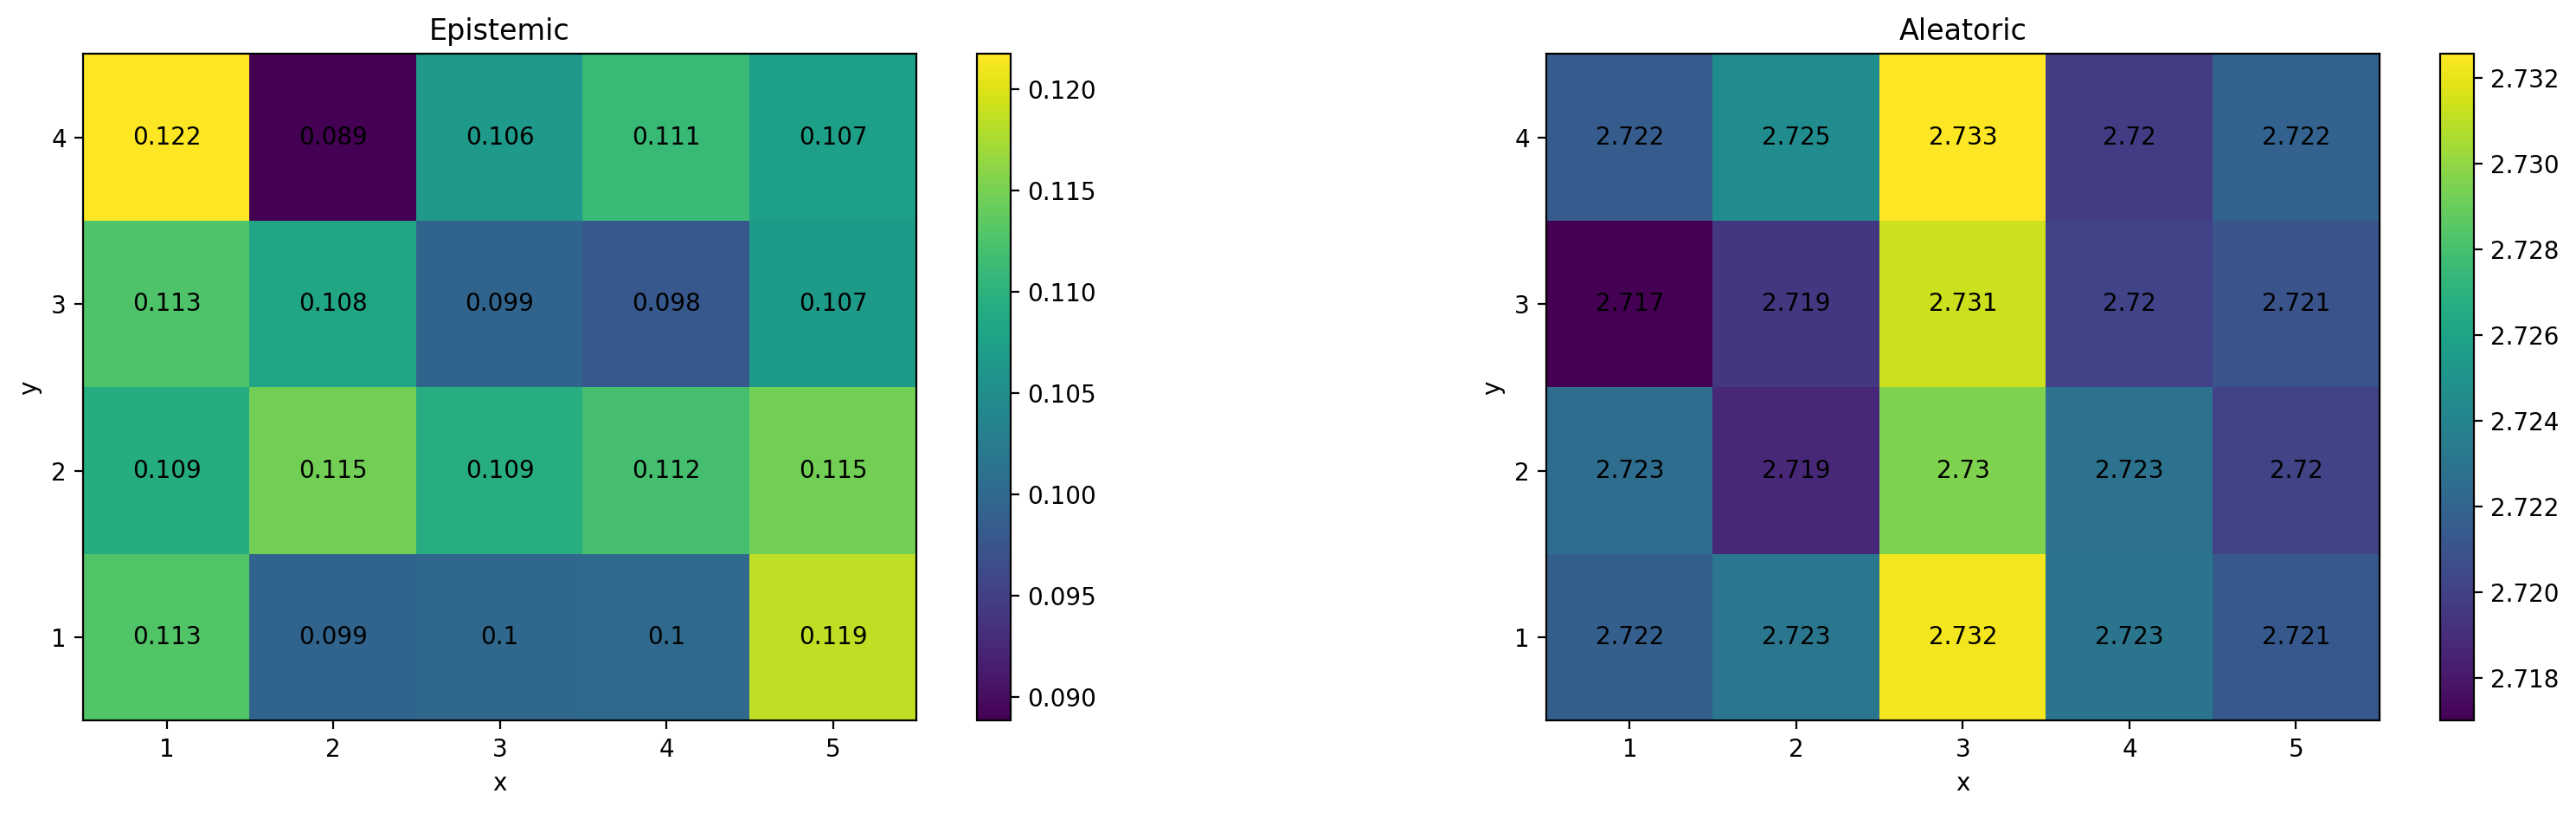

In [40]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_metn, 
                                                N, N2, L, 'UQ_Lmet_uni.png')

In [41]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_metn.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_metn.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

191265.31

## Method 2: Hamiltonian Monte Carlo (HMC)

### Identifiable HMC

#### Prior-Posterior Overlap

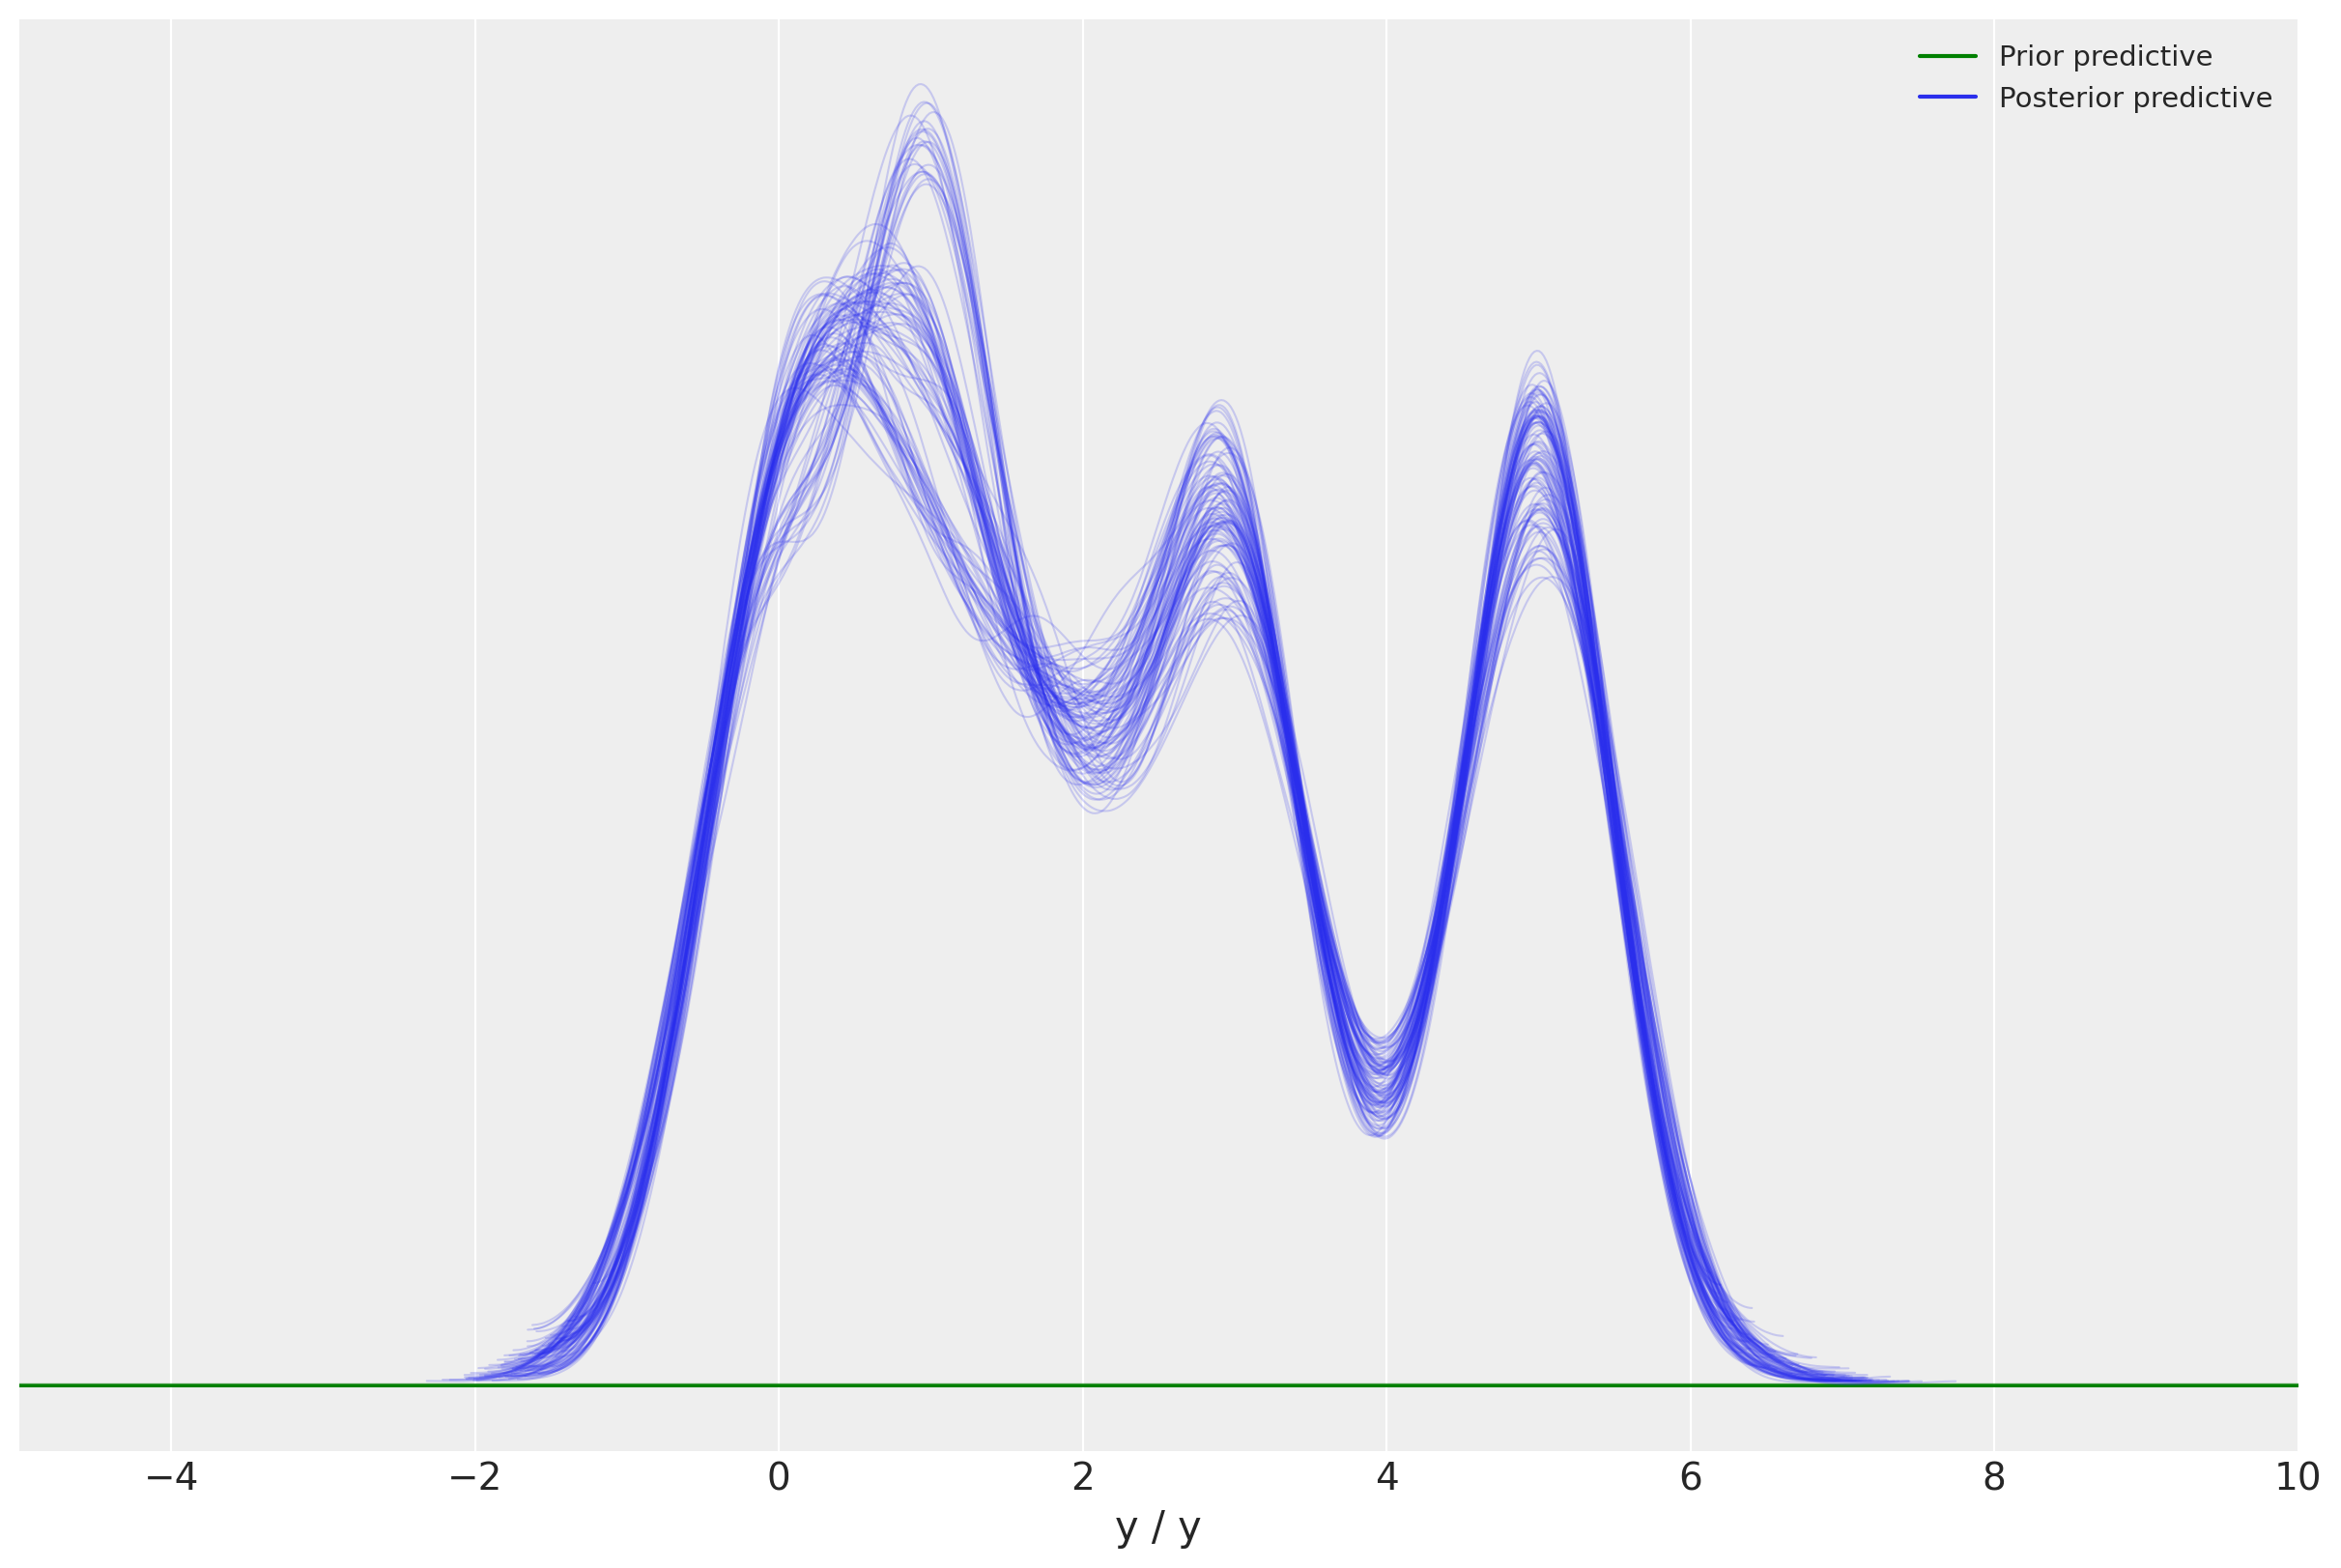

In [27]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_hmc, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_hmc, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lhmc.png', dpi=300)
plt.show()

In [28]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_hmc.observed_data 
priorpredictive_dataset = idata_hmc.prior_predictive 
postpredictive_dataset = idata_hmc.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [05:08<00:00,  3.08s/it]


0.06708884688090737

#### Uncertainty Quantification

In [29]:
post_hmc.shape

(10000, 1, 582)

In [30]:
#thinning by factor of 4
post_hmc = post_hmc[::4, :]
post_hmc.shape

(2500, 1, 582)

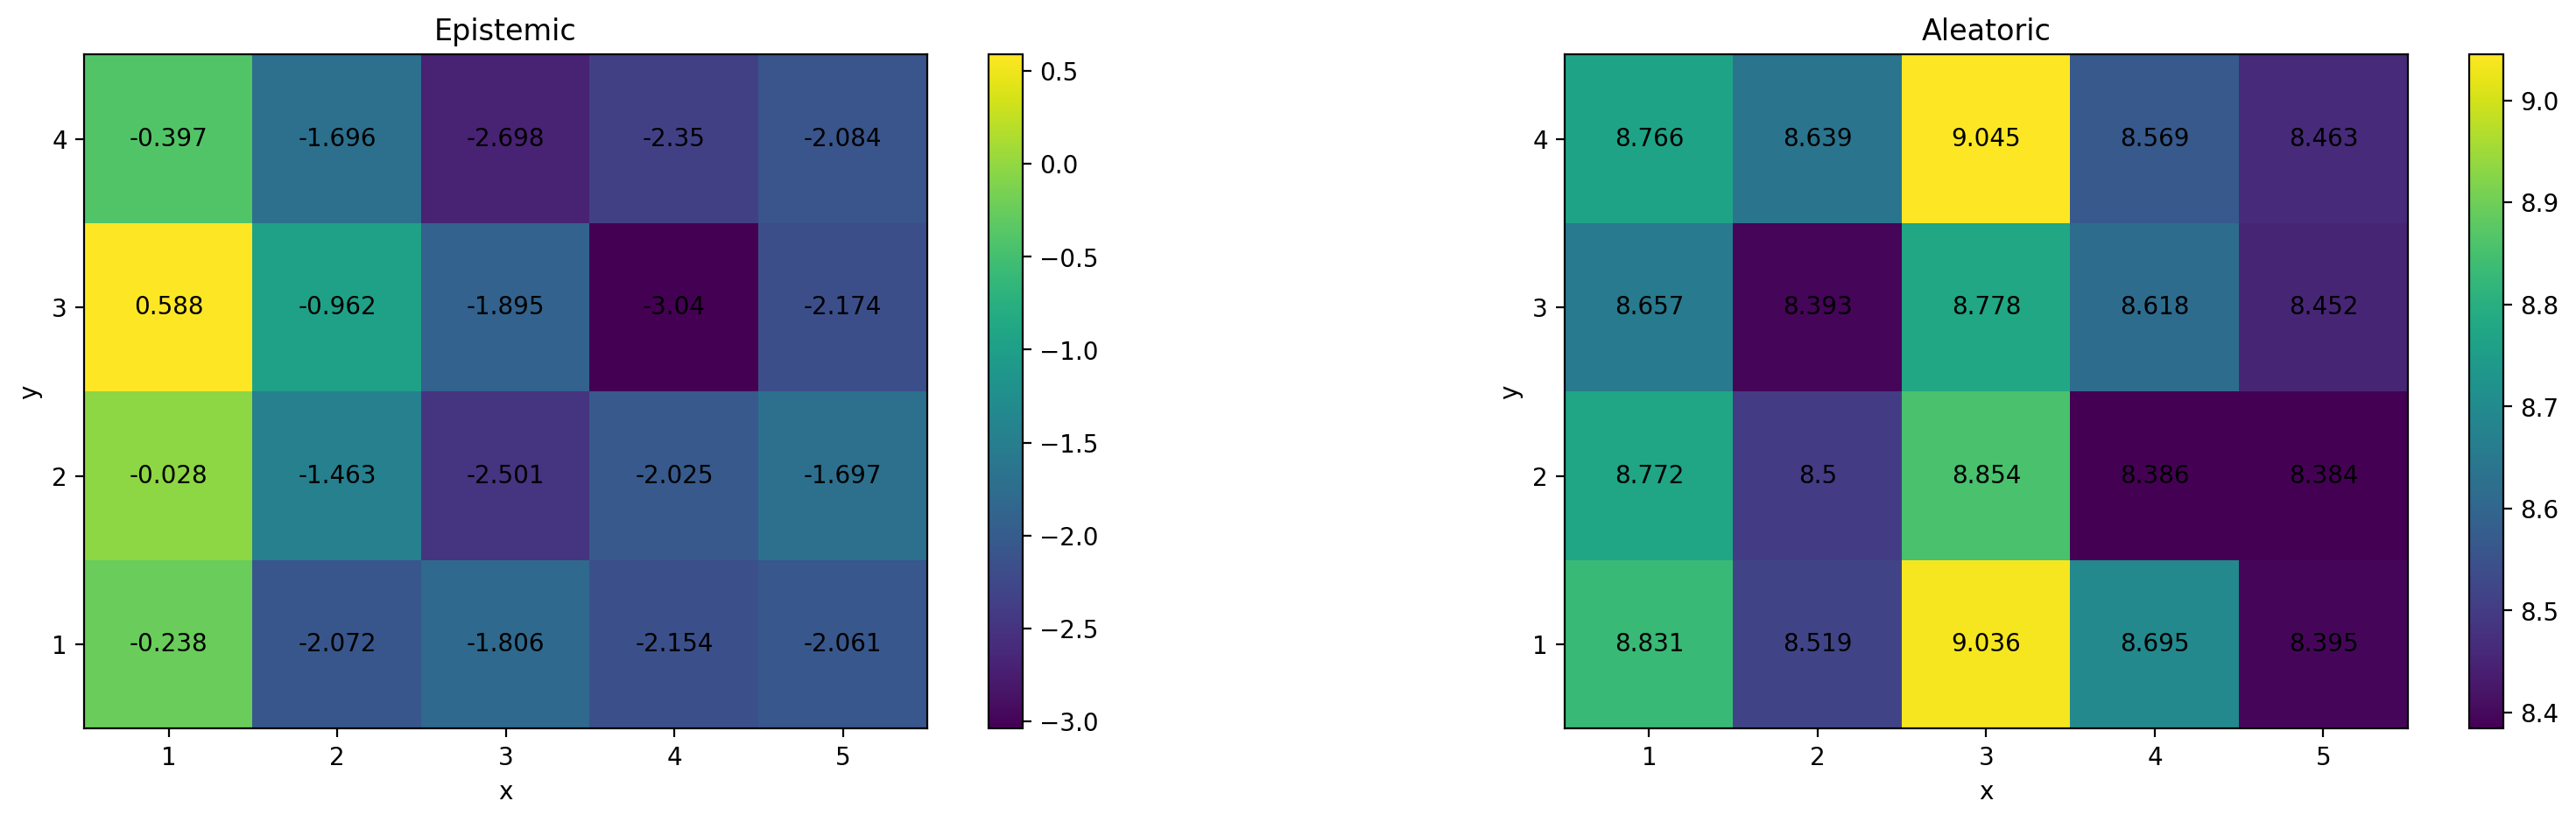

In [31]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_hmc, 
                                                N, N2, L, 'UQ_Lhmc.png')

In [32]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_hmc.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_hmc.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

3122.022

### Non-identifiable HMC

#### Prior-Posterior Overlap

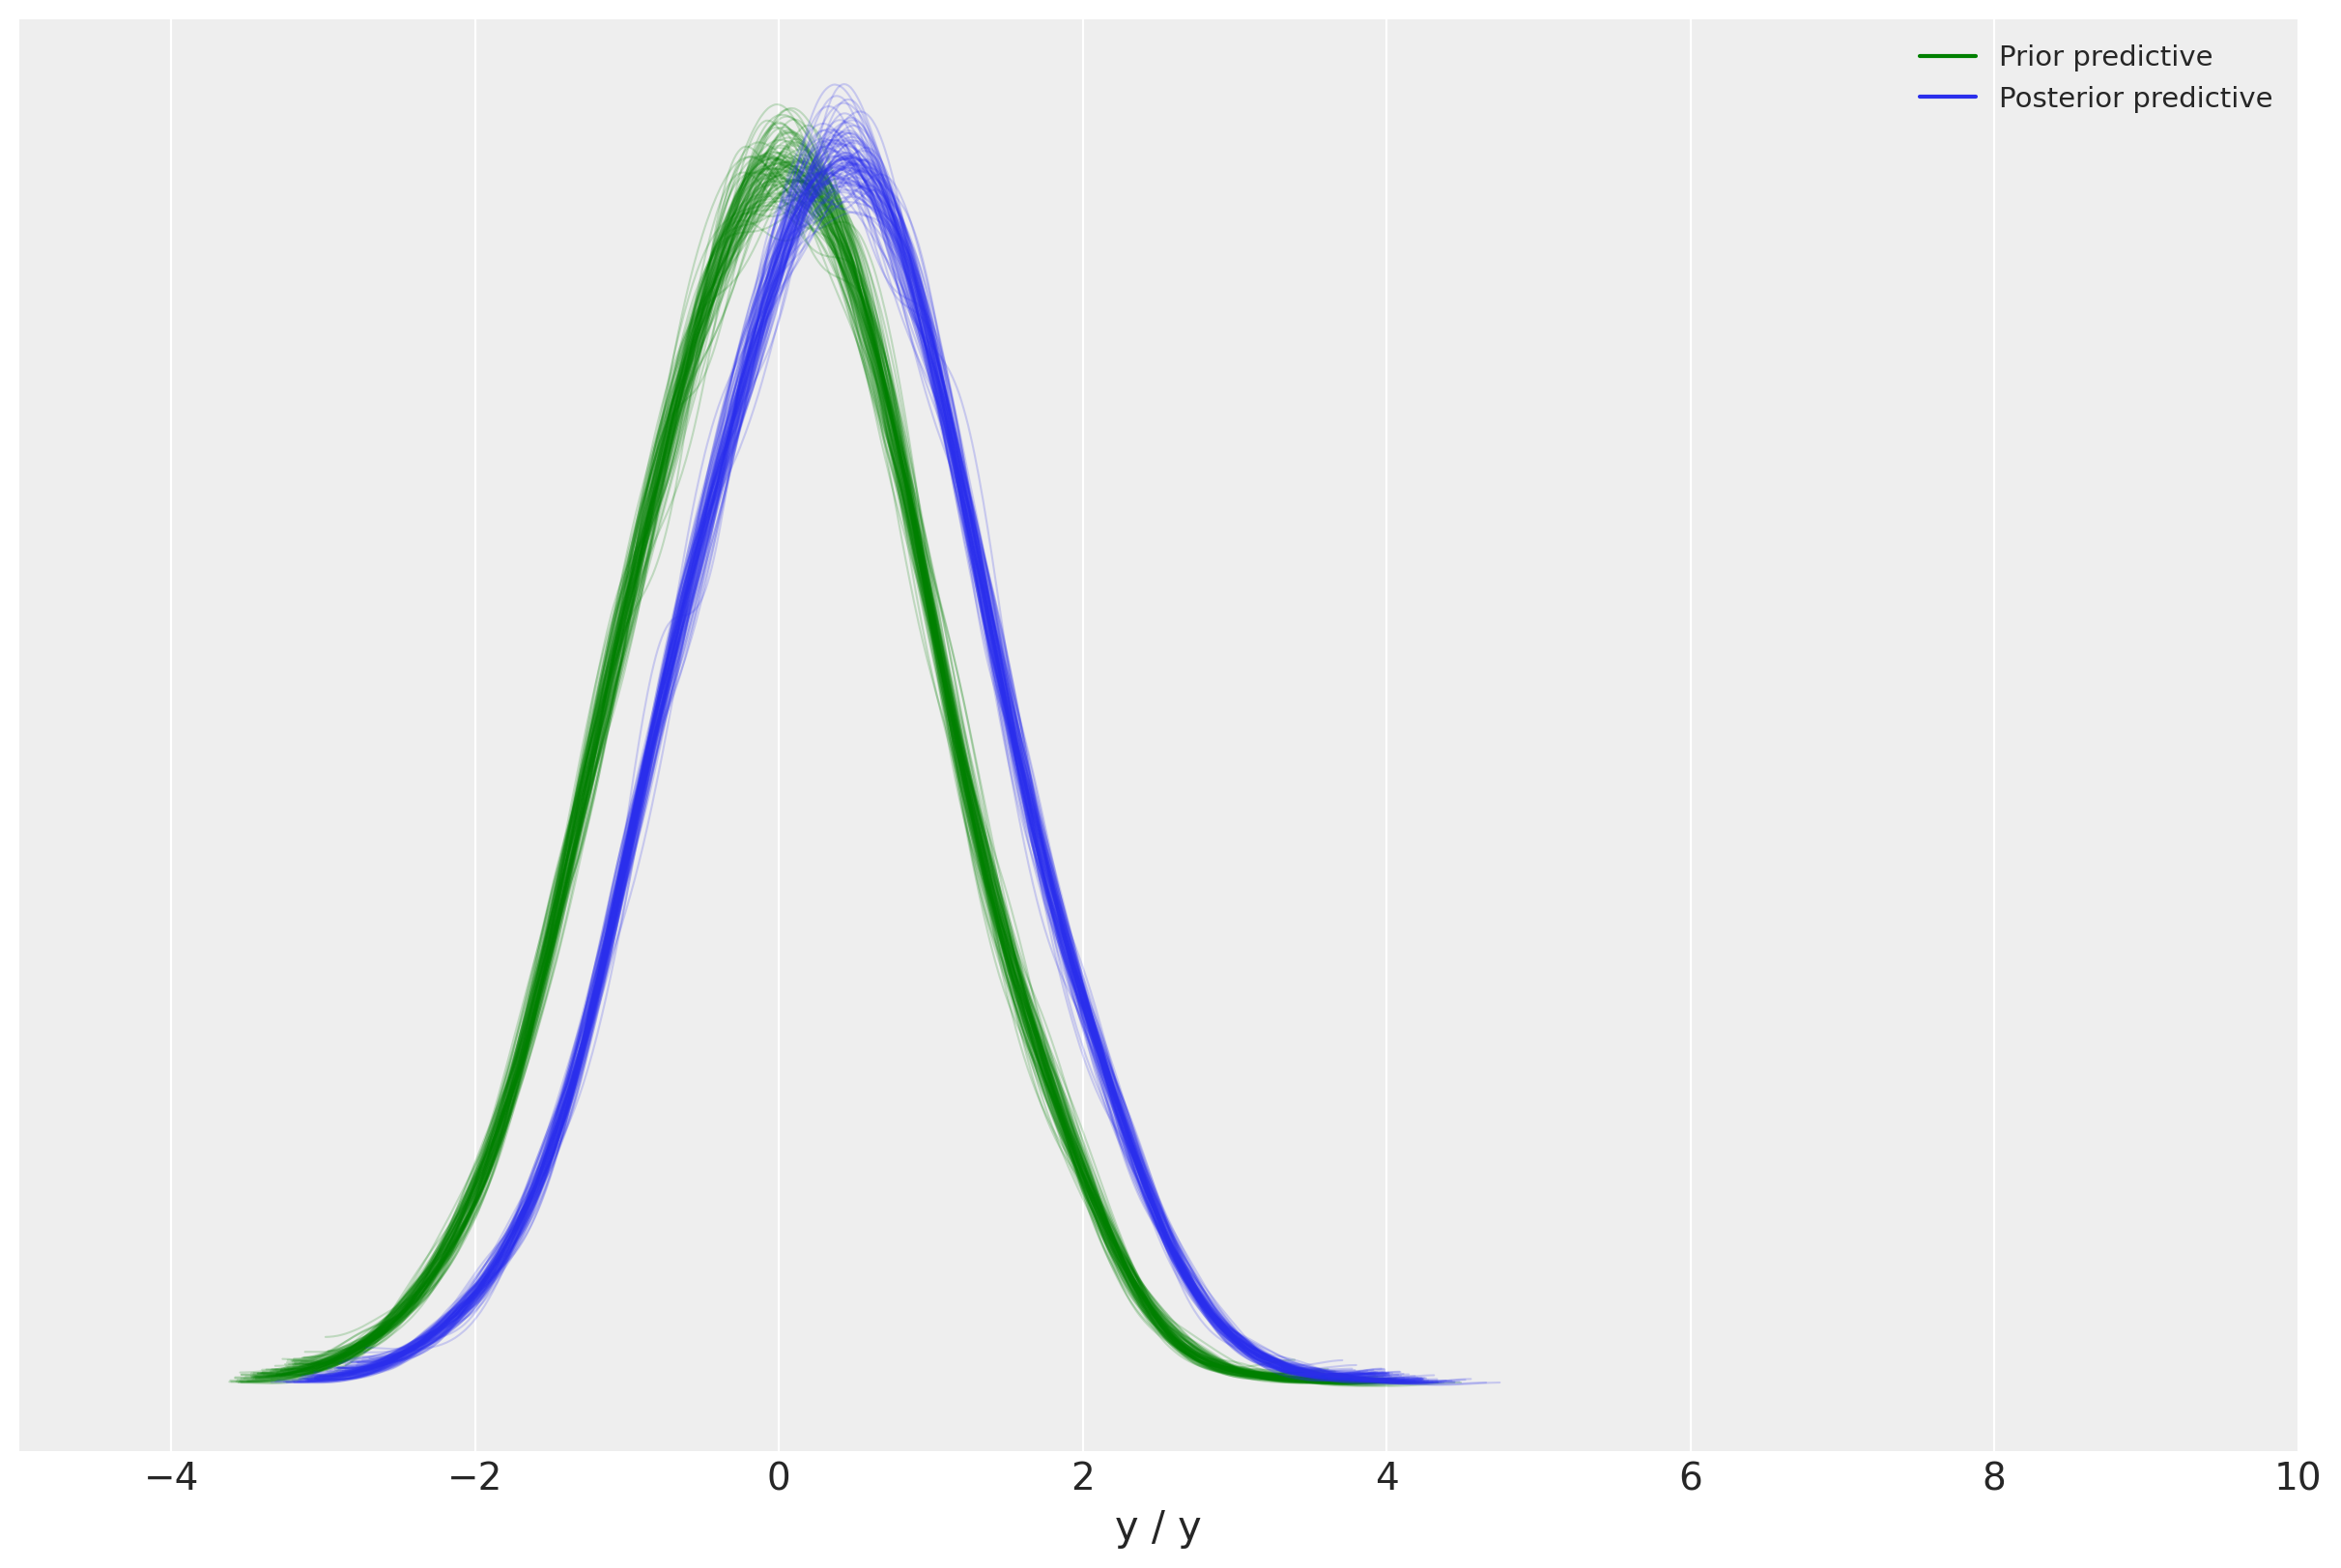

In [33]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_hmcn, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_hmcn, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lhmc_uni.png', dpi=300)
plt.show()

In [34]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_hmcn.observed_data 
priorpredictive_dataset = idata_hmcn.prior_predictive 
postpredictive_dataset = idata_hmcn.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [04:56<00:00,  2.97s/it]


0.8532086011342155

#### Uncertainty Quantification

In [35]:
post_hmcn.shape

(10000, 1, 582)

In [36]:
#thinning by factor of 4
post_hmcn = post_hmcn[::4, :]
post_hmcn.shape

(2500, 1, 582)

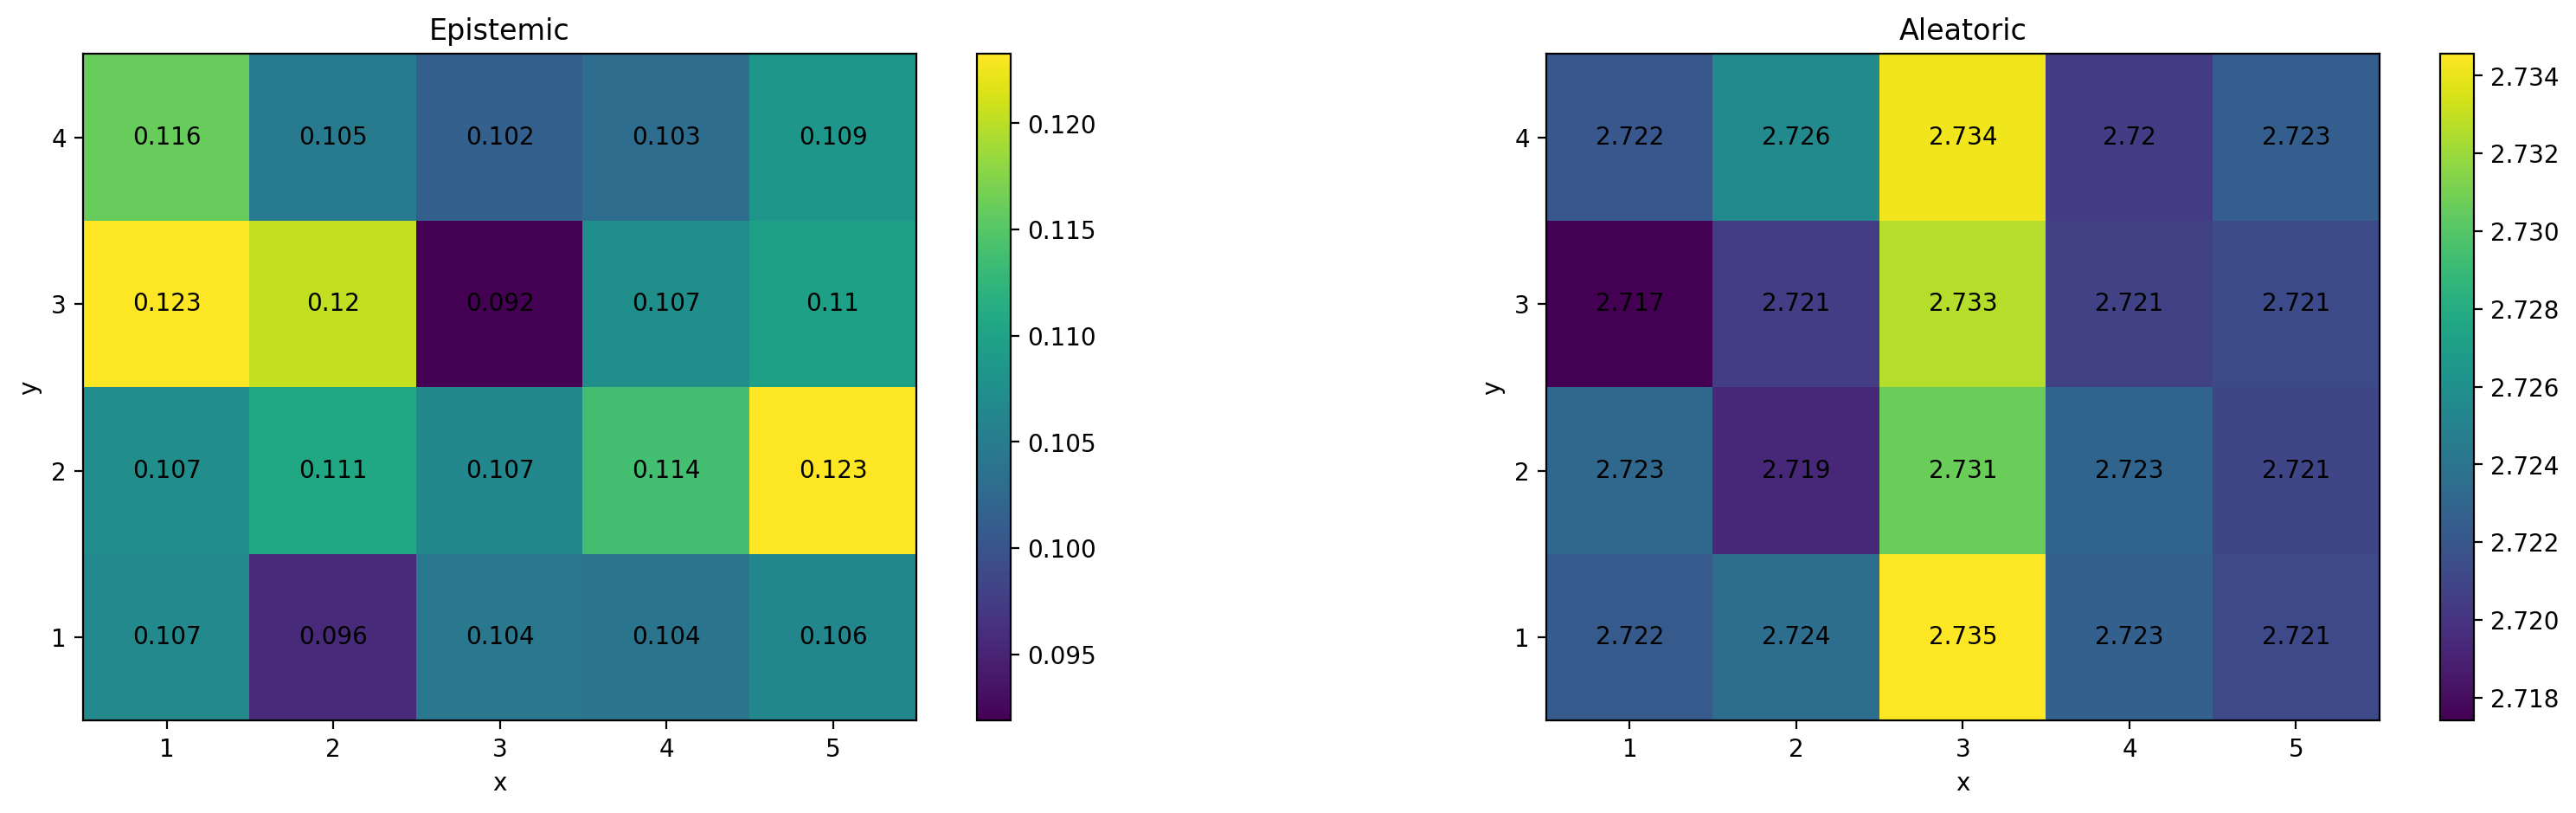

In [37]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_hmcn, 
                                                N, N2, L, 'UQ_Lhmc_uni.png')

In [38]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_hmcn.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_hmcn.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

197131.289

## Method 3: No-U-Turn Samper (NUTS)

### Identifiable NUTS

#### Prior-Posterior Overlap

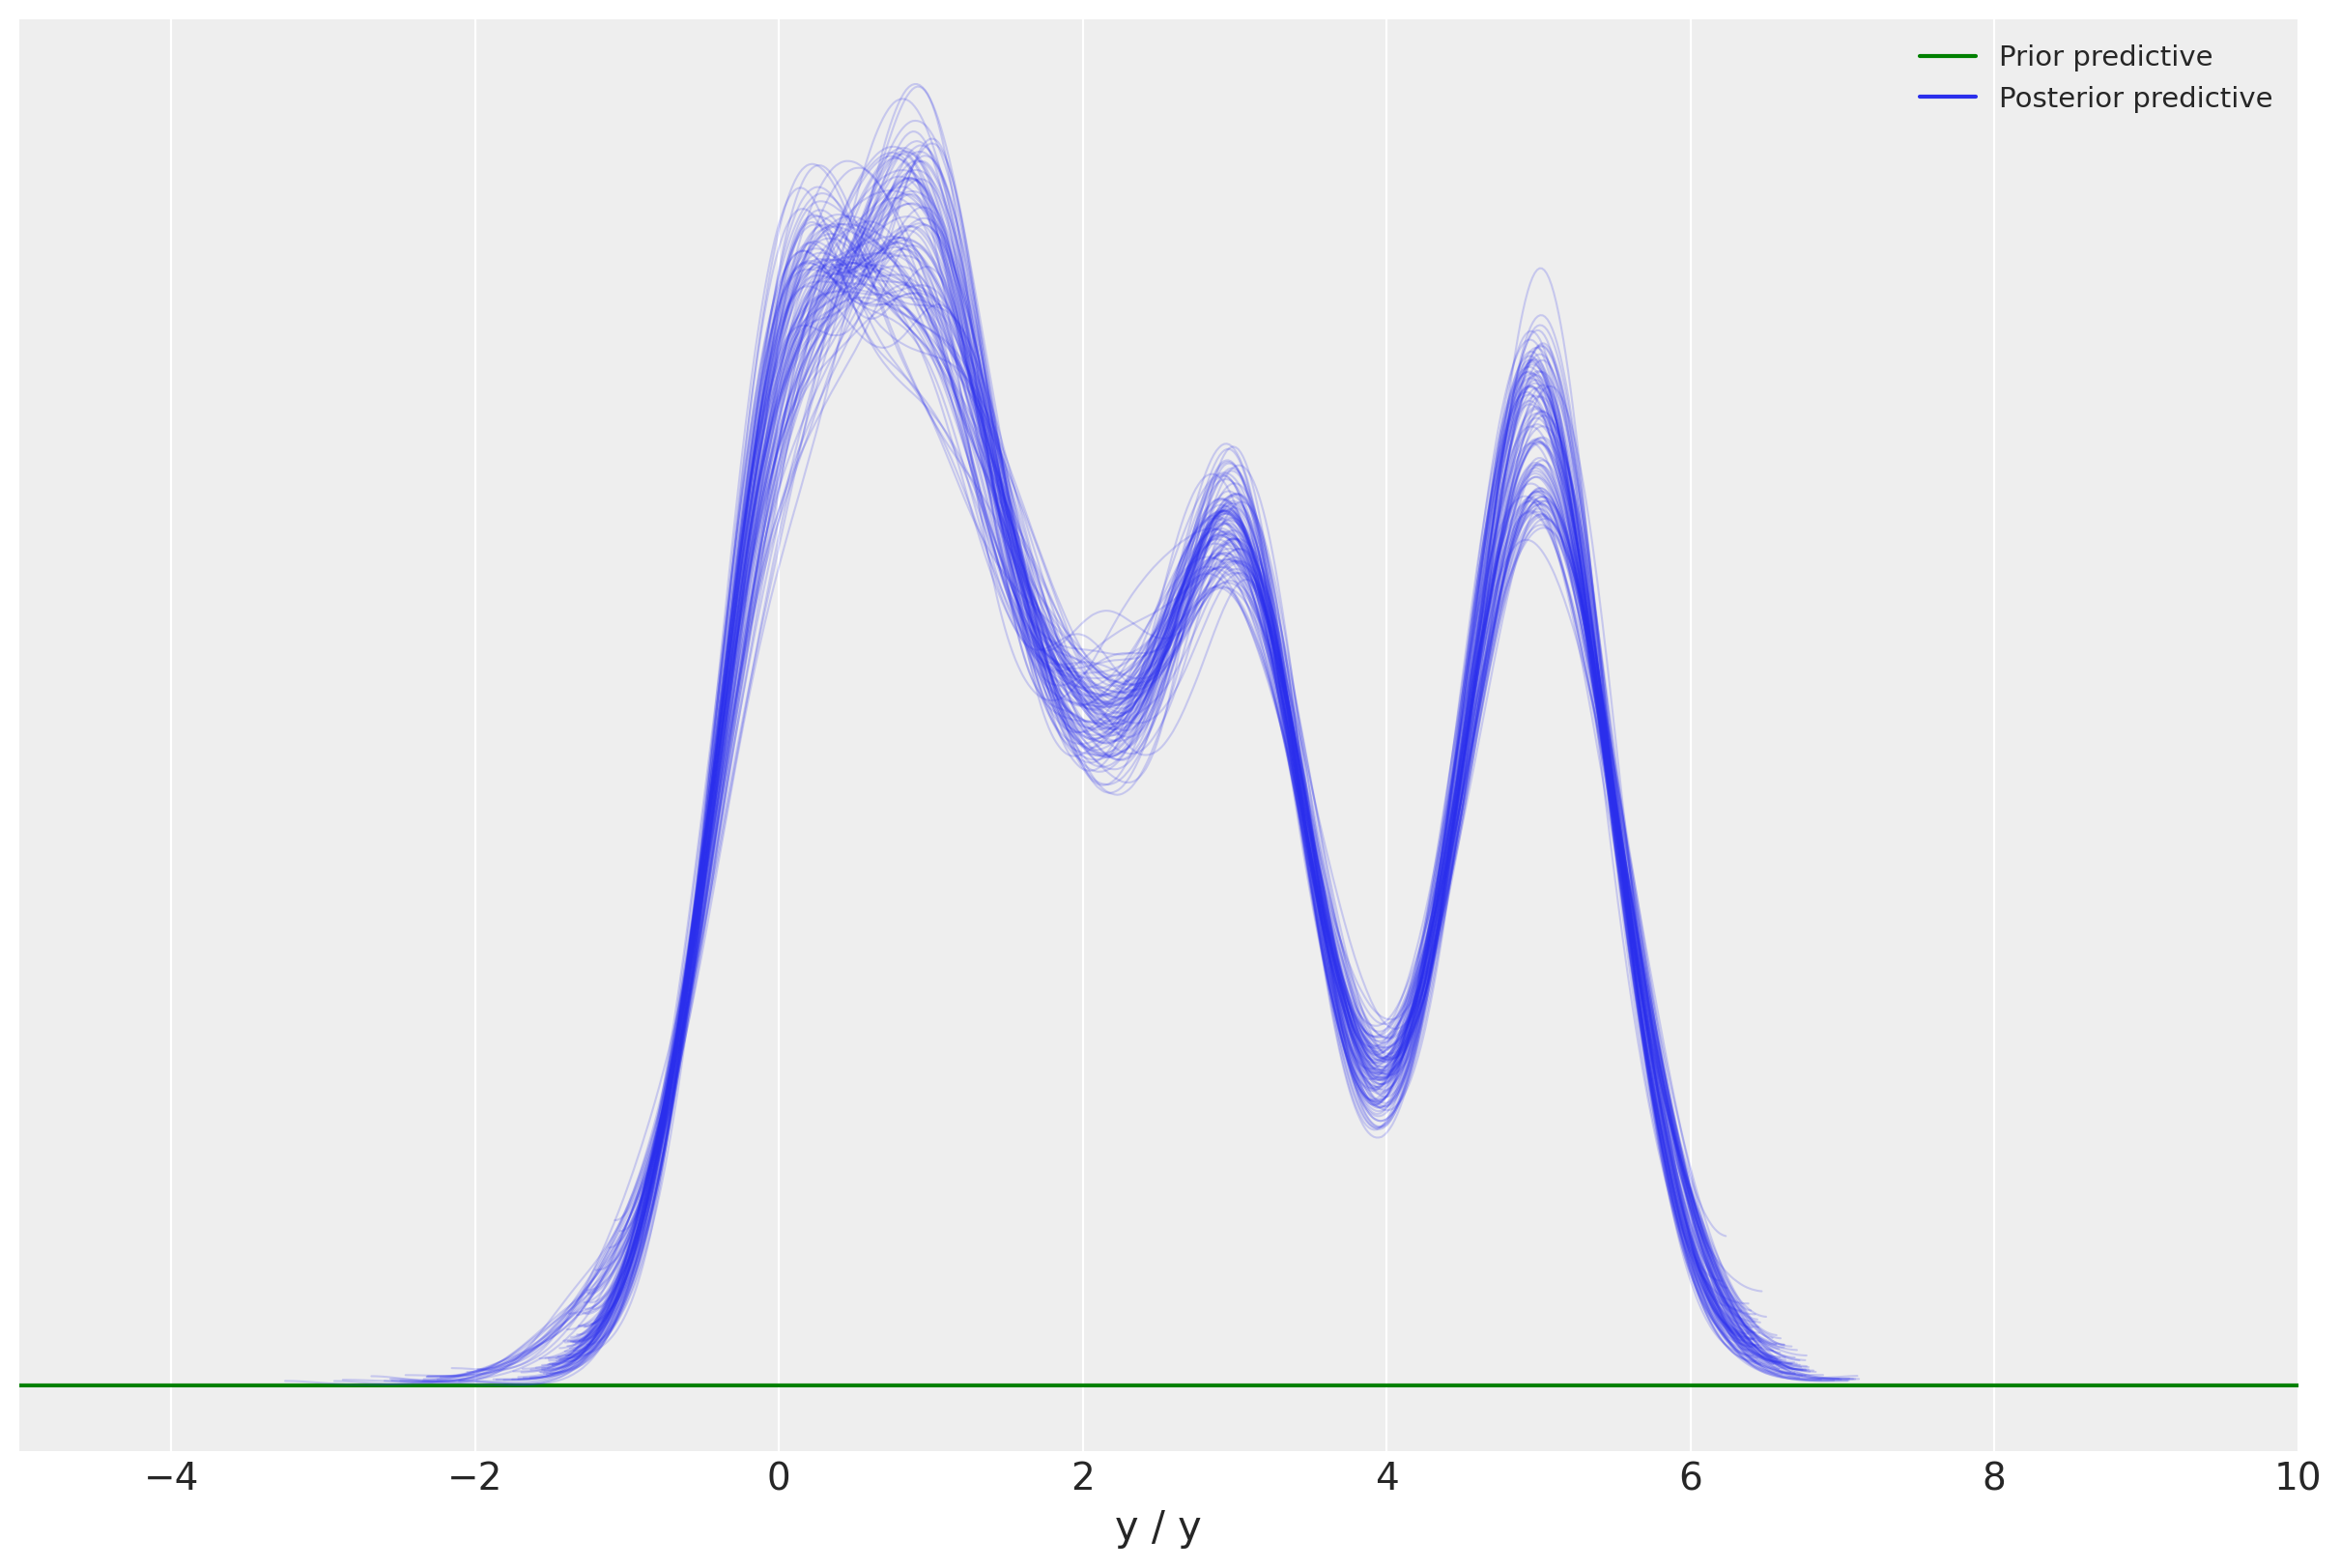

In [39]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_nuts, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_nuts, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lnuts.png', dpi=300)
plt.show()

In [40]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_nuts.observed_data 
priorpredictive_dataset = idata_nuts.prior_predictive 
postpredictive_dataset = idata_nuts.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


0.04060932577189666

#### Uncertainty Quantification

In [41]:
post_nuts.shape

(1600, 1, 582)

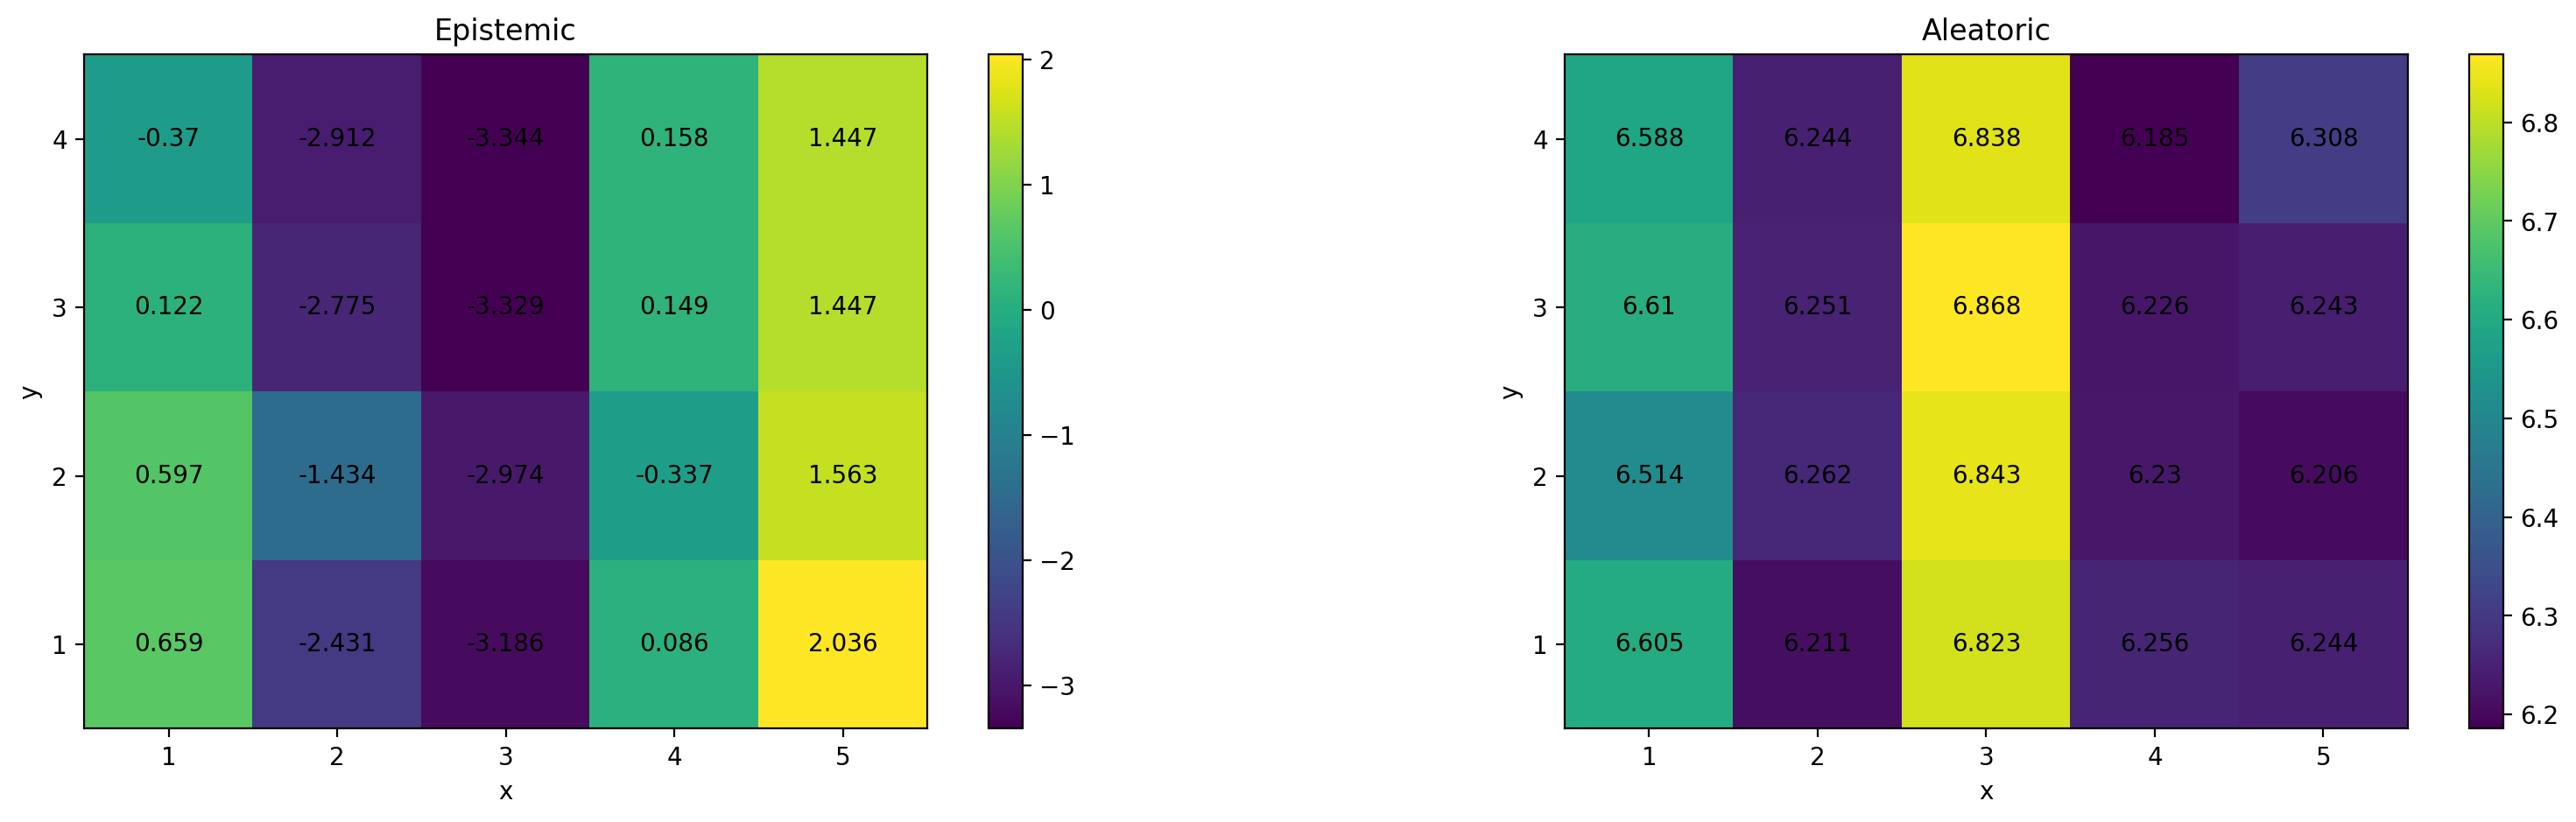

In [73]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_nuts, 
                                                N, N2, L, 'UQ_Lnuts.png')

In [43]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_nuts.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_nuts.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

1874.028

### Non-identifiable NUTS

#### Prior-Posterior Overlap

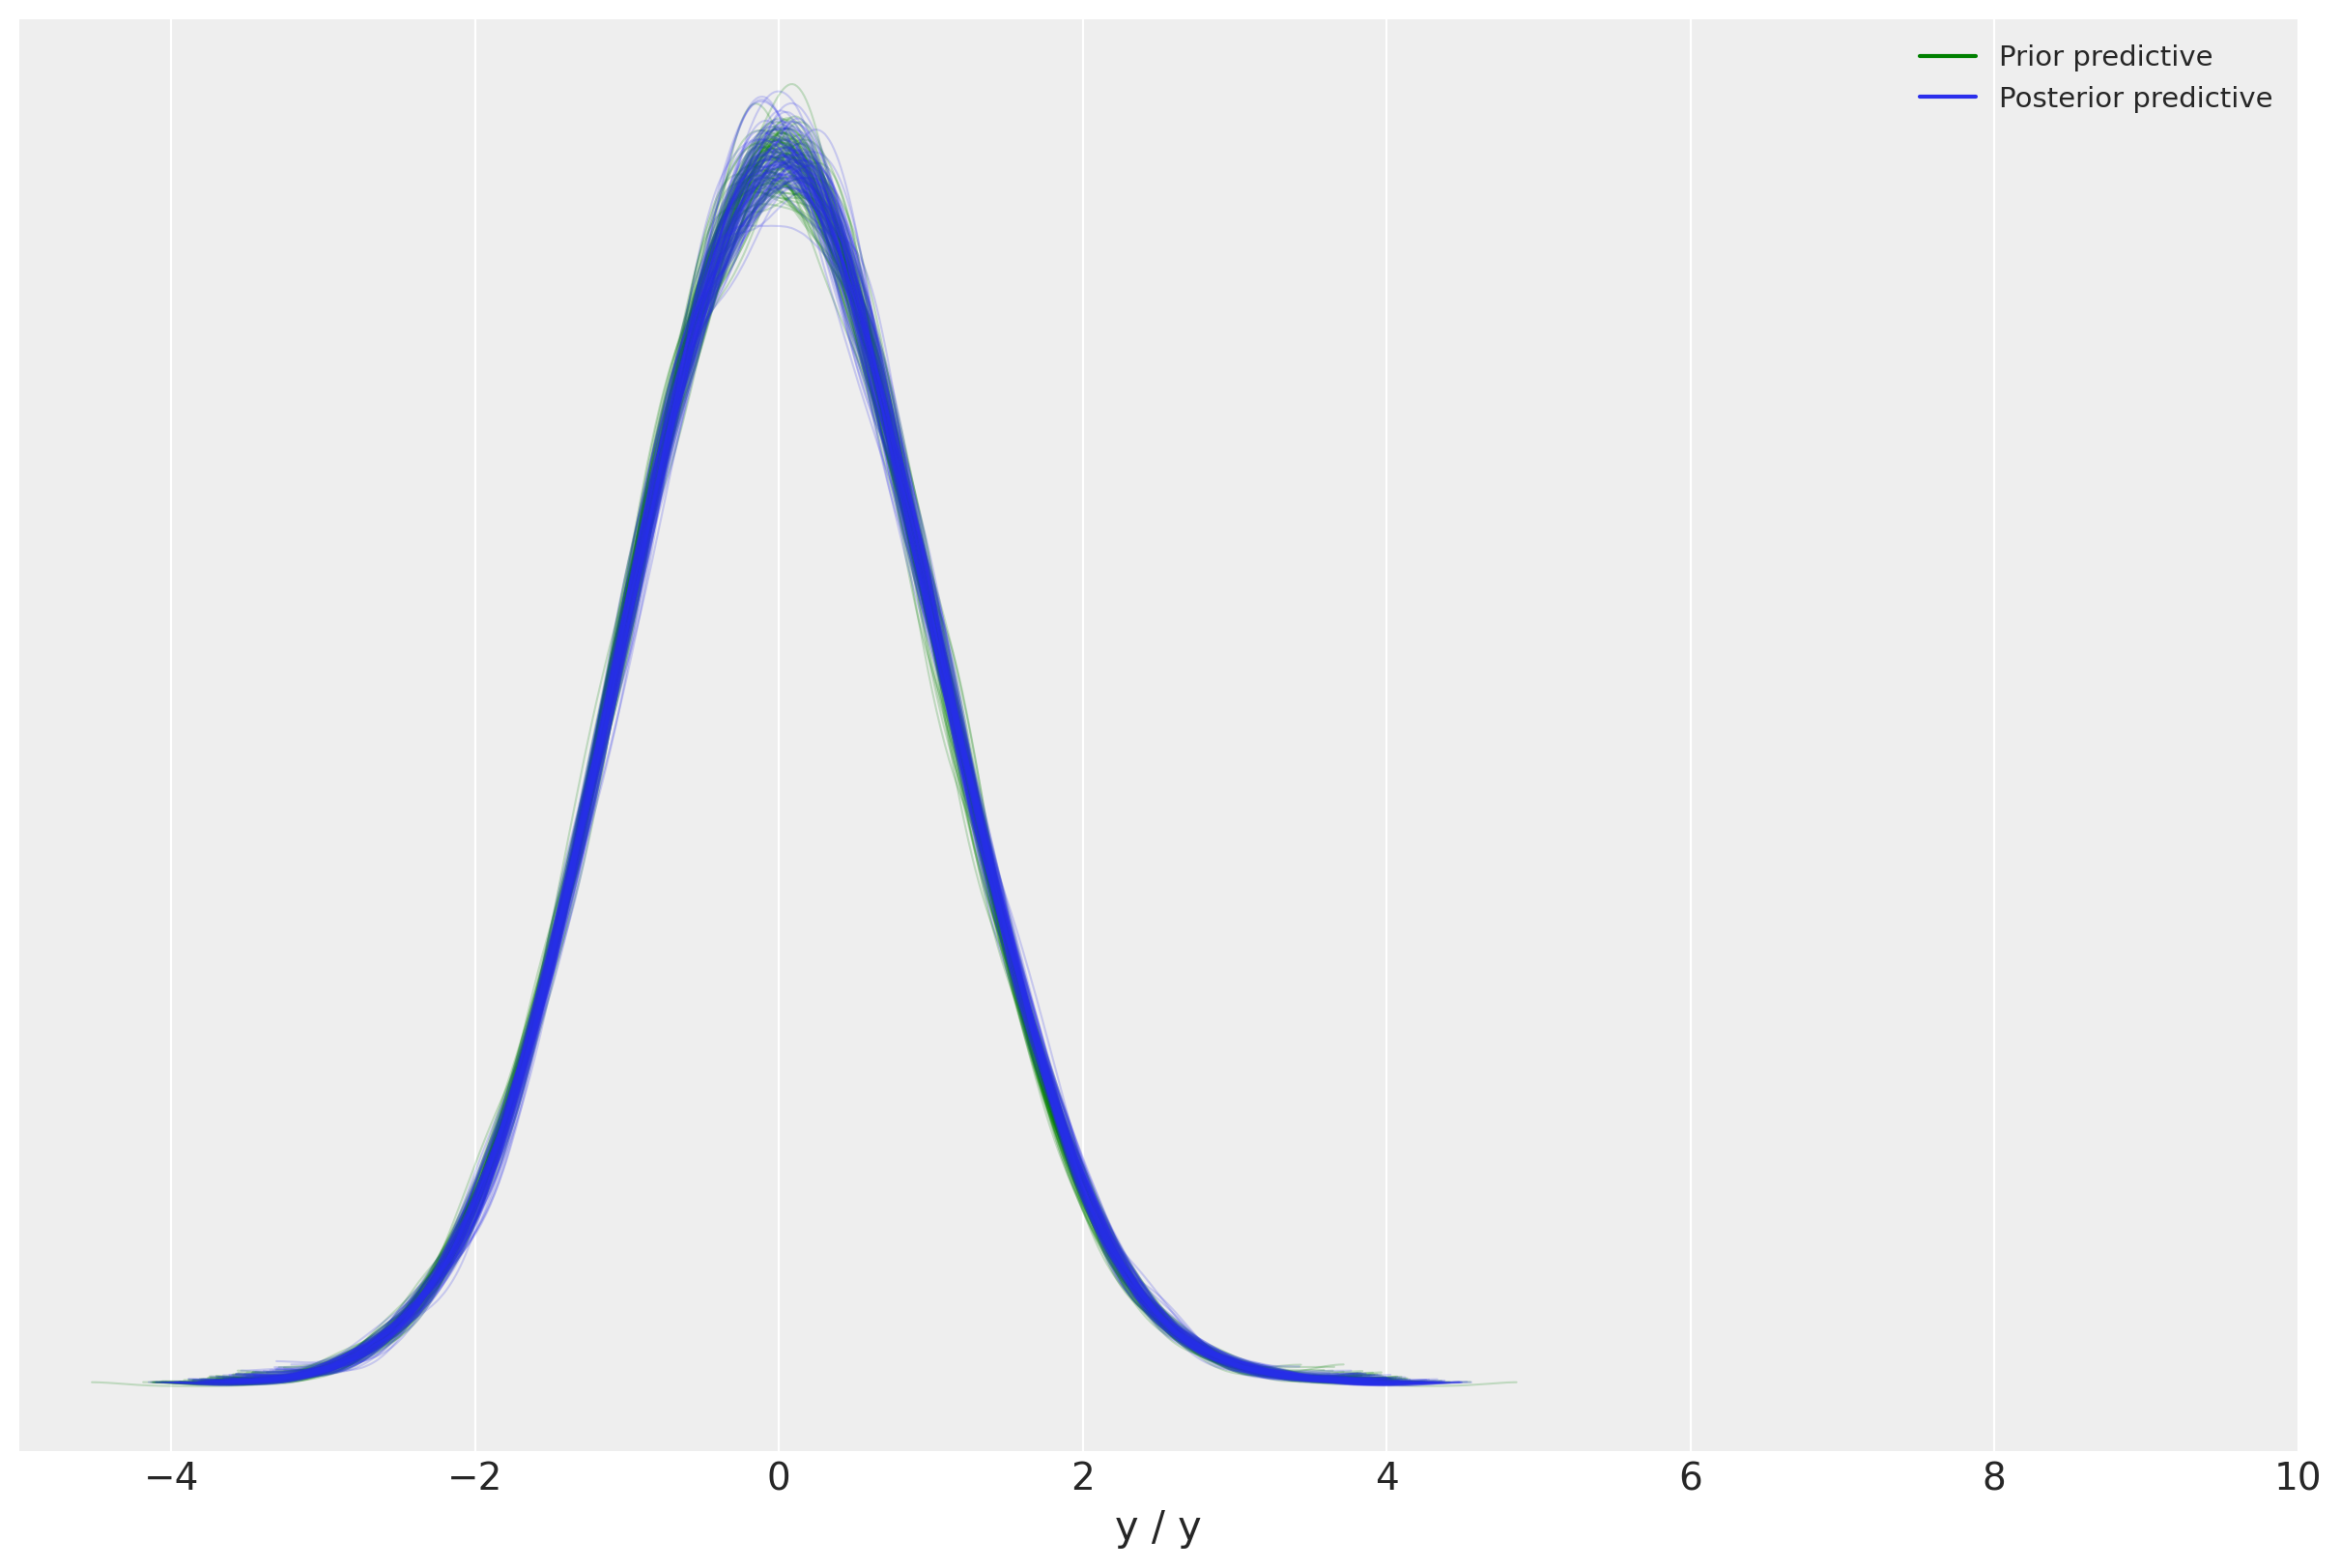

In [44]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_nutsn, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_nutsn, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lnuts_uni.png', dpi=300)
plt.show()

In [45]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_nutsn.observed_data 
priorpredictive_dataset = idata_nutsn.prior_predictive 
postpredictive_dataset = idata_nutsn.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


0.9954077268431001

#### Uncertainty Quantification

In [46]:
post_nutsn.shape

(1600, 1, 582)

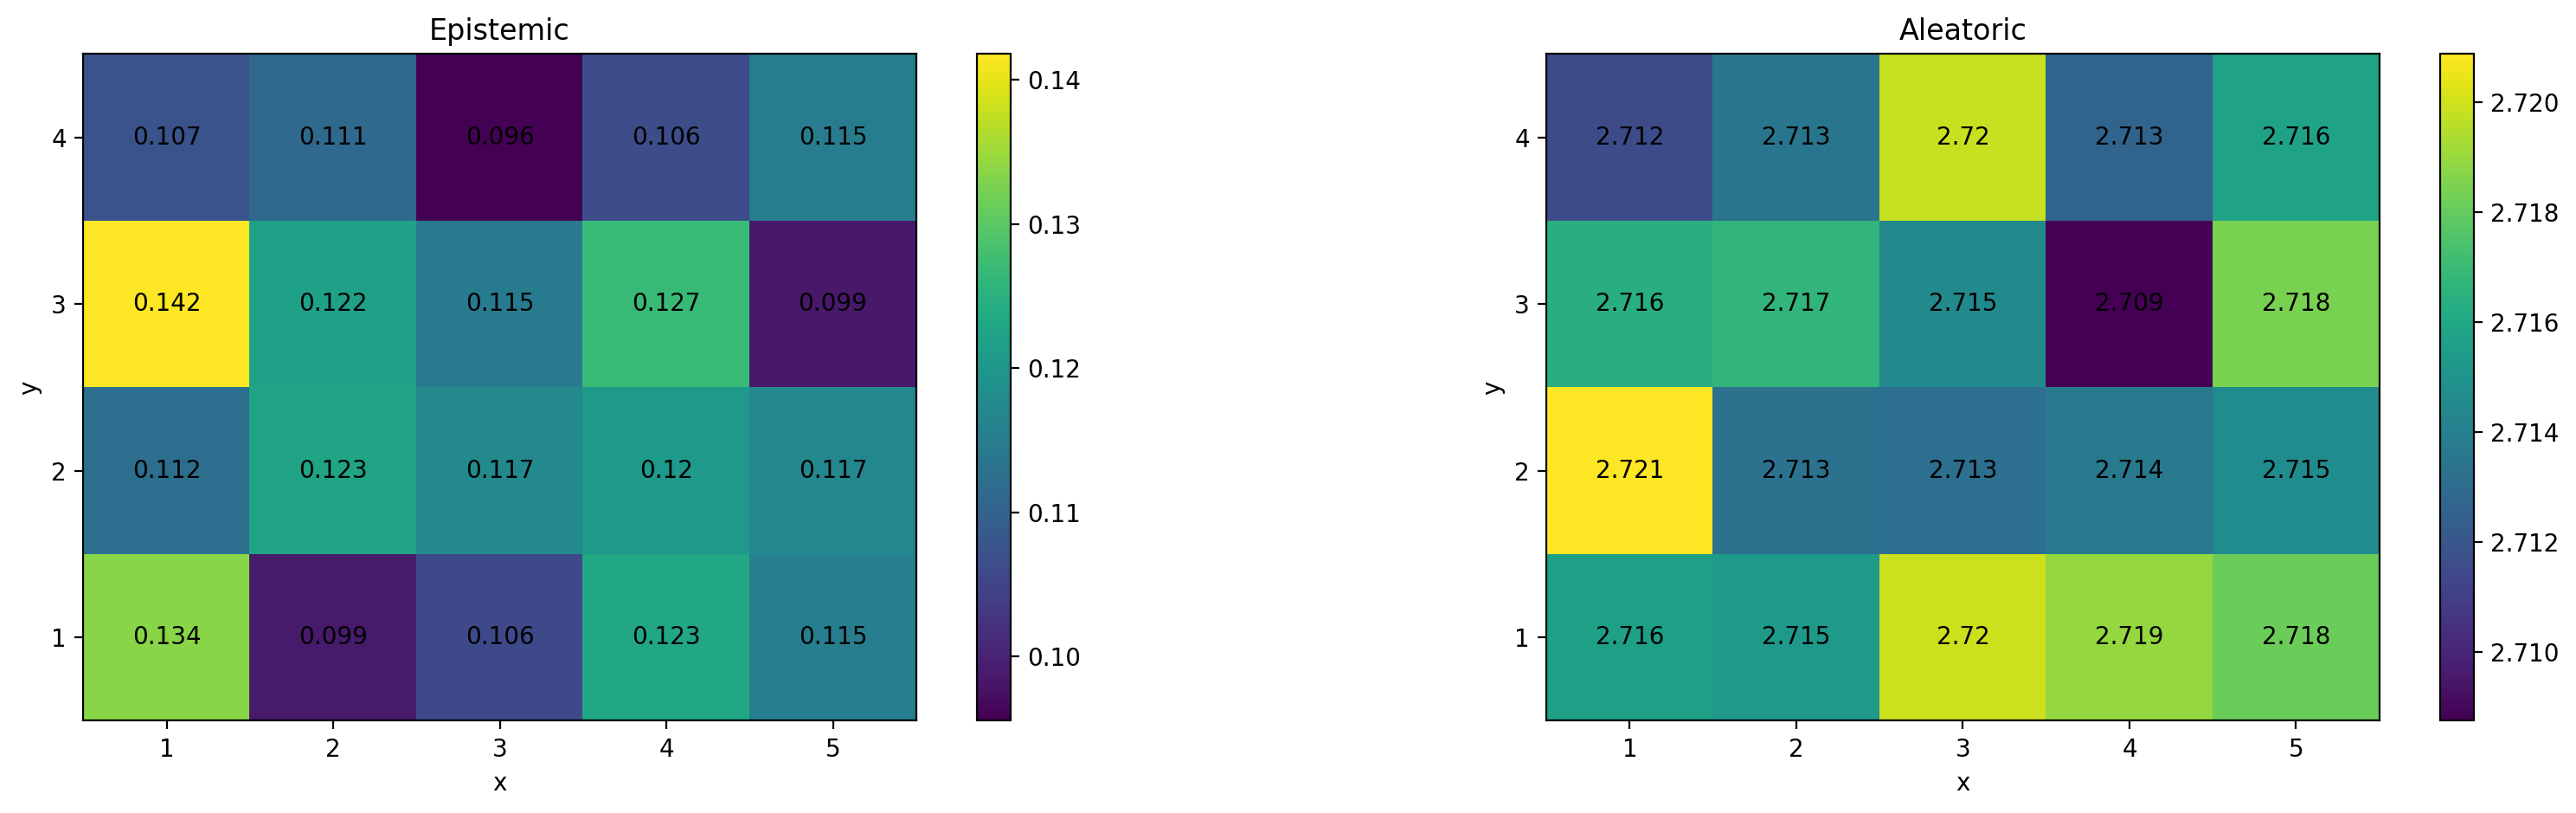

In [47]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_nutsn, 
                                                N, N2, L, 'UQ_Lnuts_uni.png')

In [48]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_nutsn.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_nutsn.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

239571.364

## Method 4: Automatic Differentiation Variational Inference (ADVI)

### Identifiable ADVI

#### Prior-Posterior Overlap

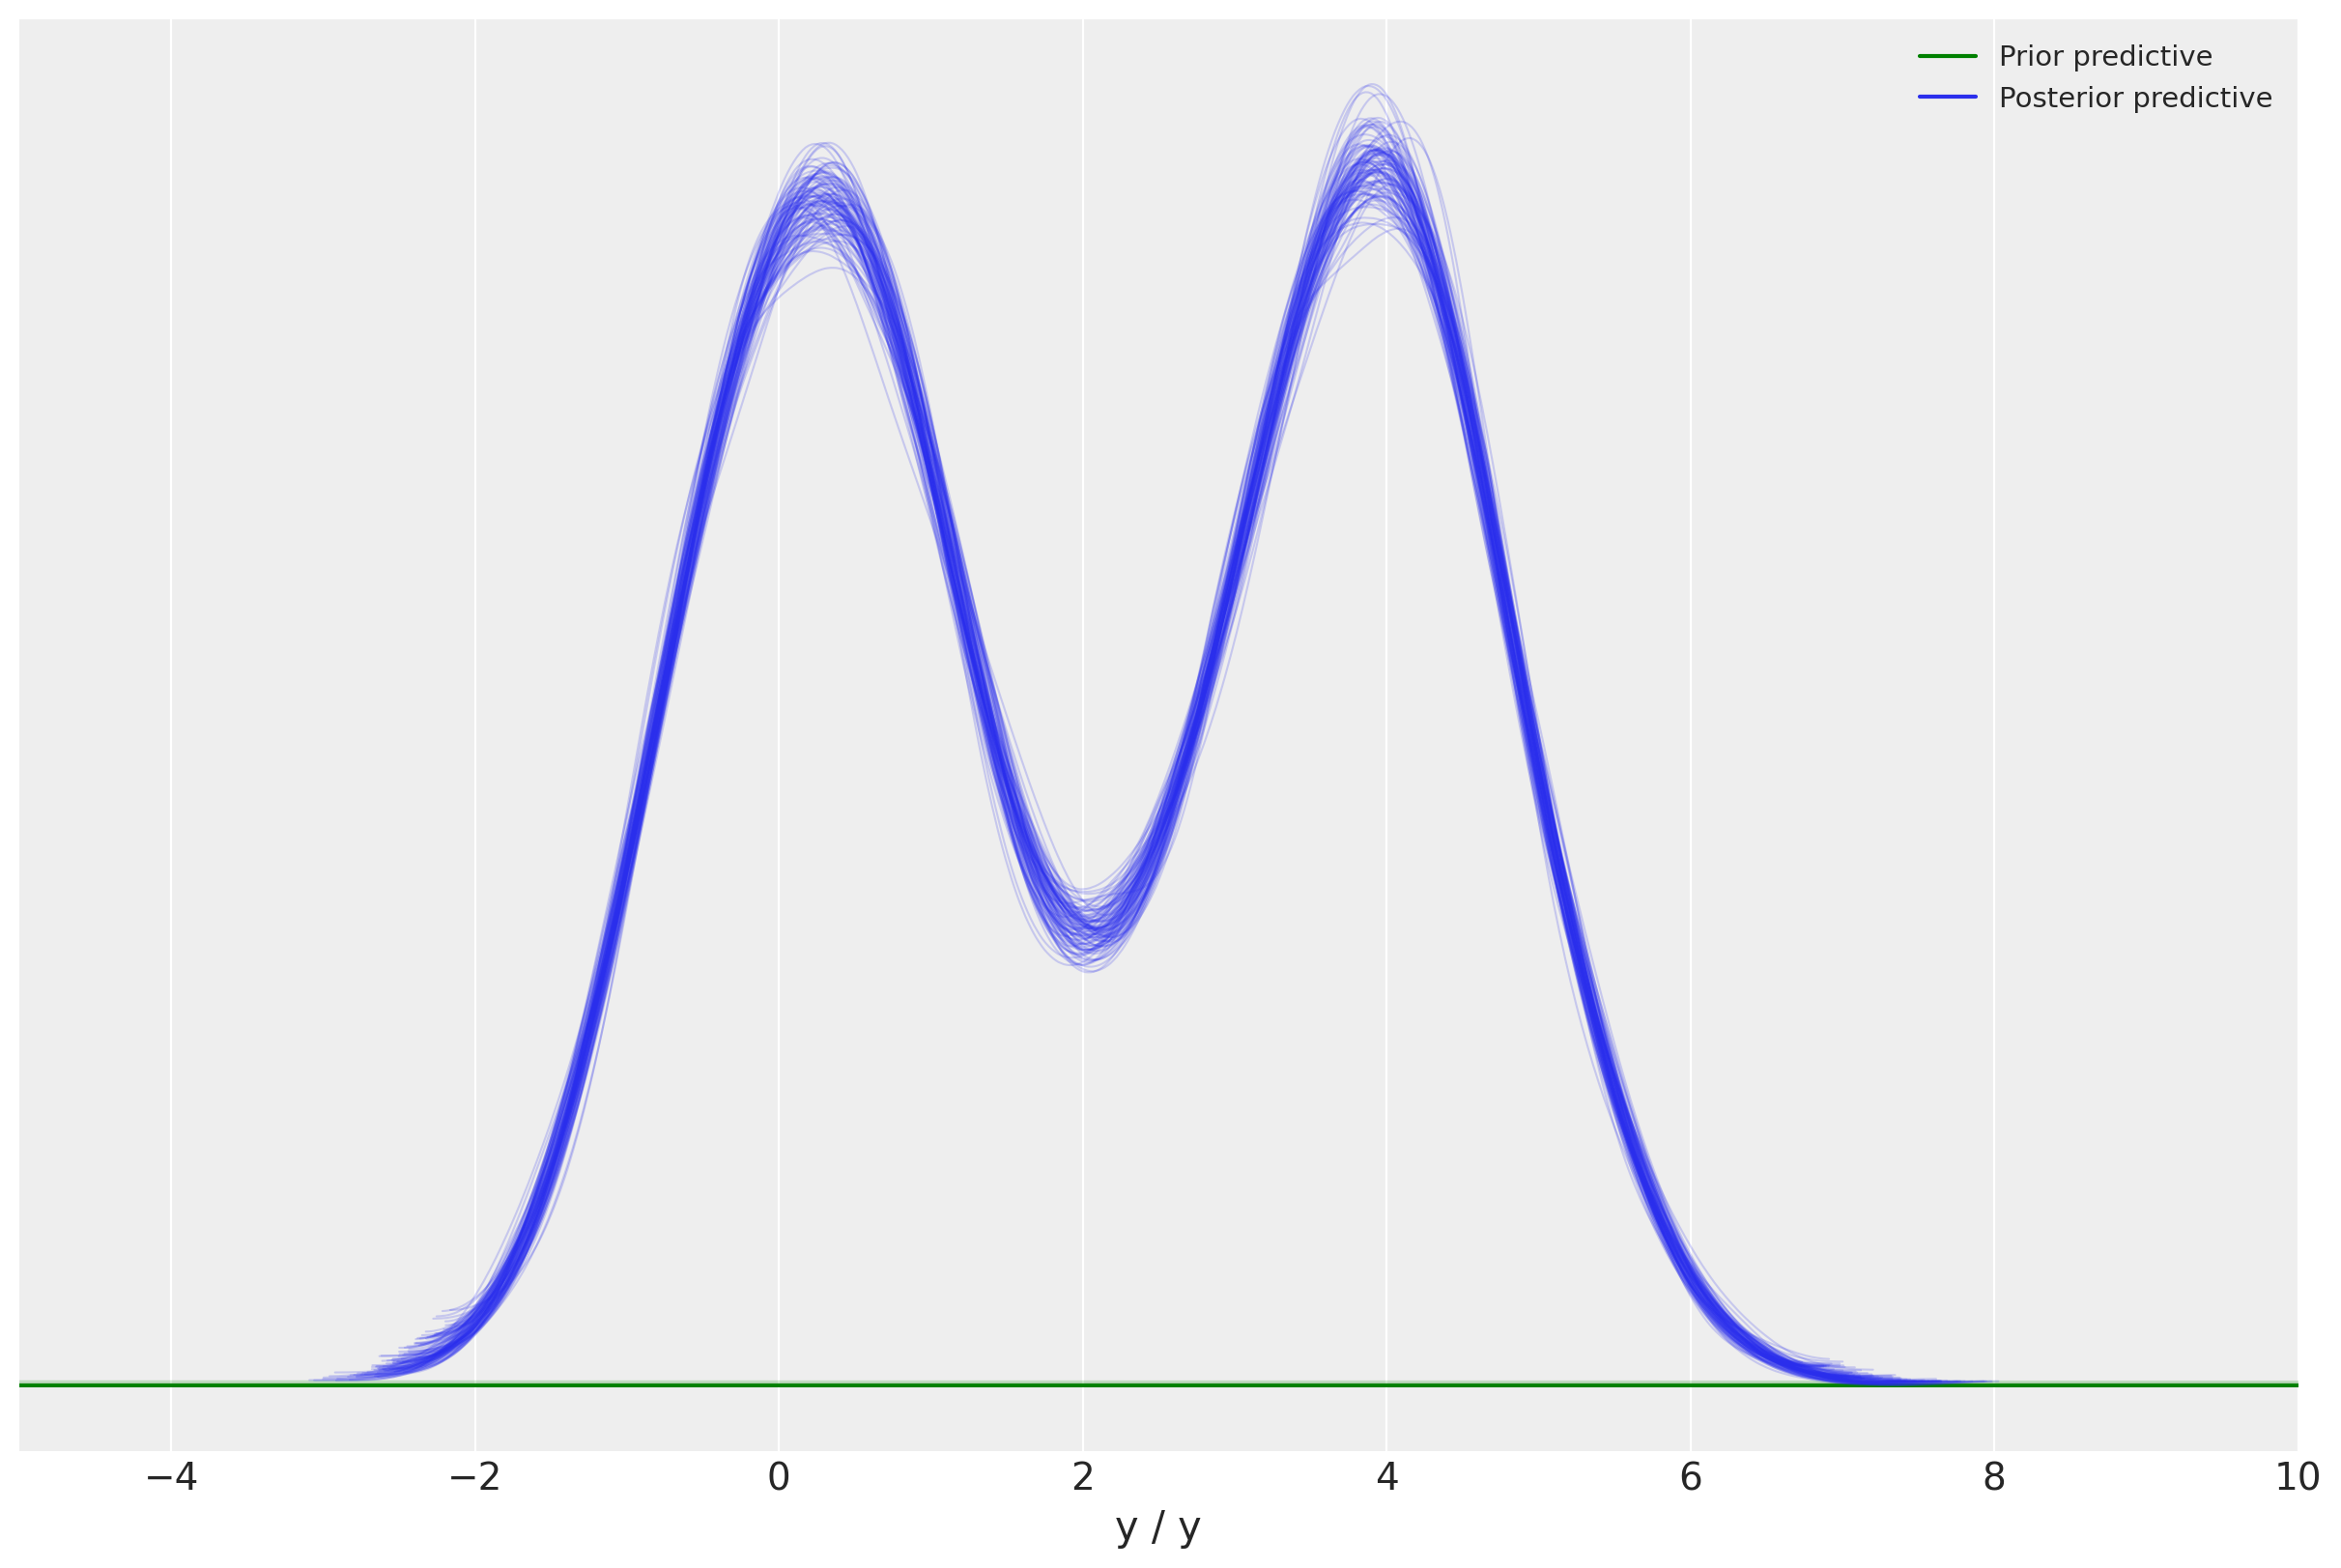

In [49]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_advi, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_advi, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Ladvi.png', dpi=300)
plt.show()

In [50]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_advi.observed_data #change idata to ADVI specific name
priorpredictive_dataset = idata_advi.prior_predictive 
postpredictive_dataset = idata_advi.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [14:52<00:00,  8.92s/it]


0.060172715894868584

#### Uncertainty Quantification

In [51]:
post_advi.shape

(30000, 1, 582)

In [52]:
#thinning by factor of 12
post_advi = post_advi[::12, :]
post_advi.shape

(2500, 1, 582)

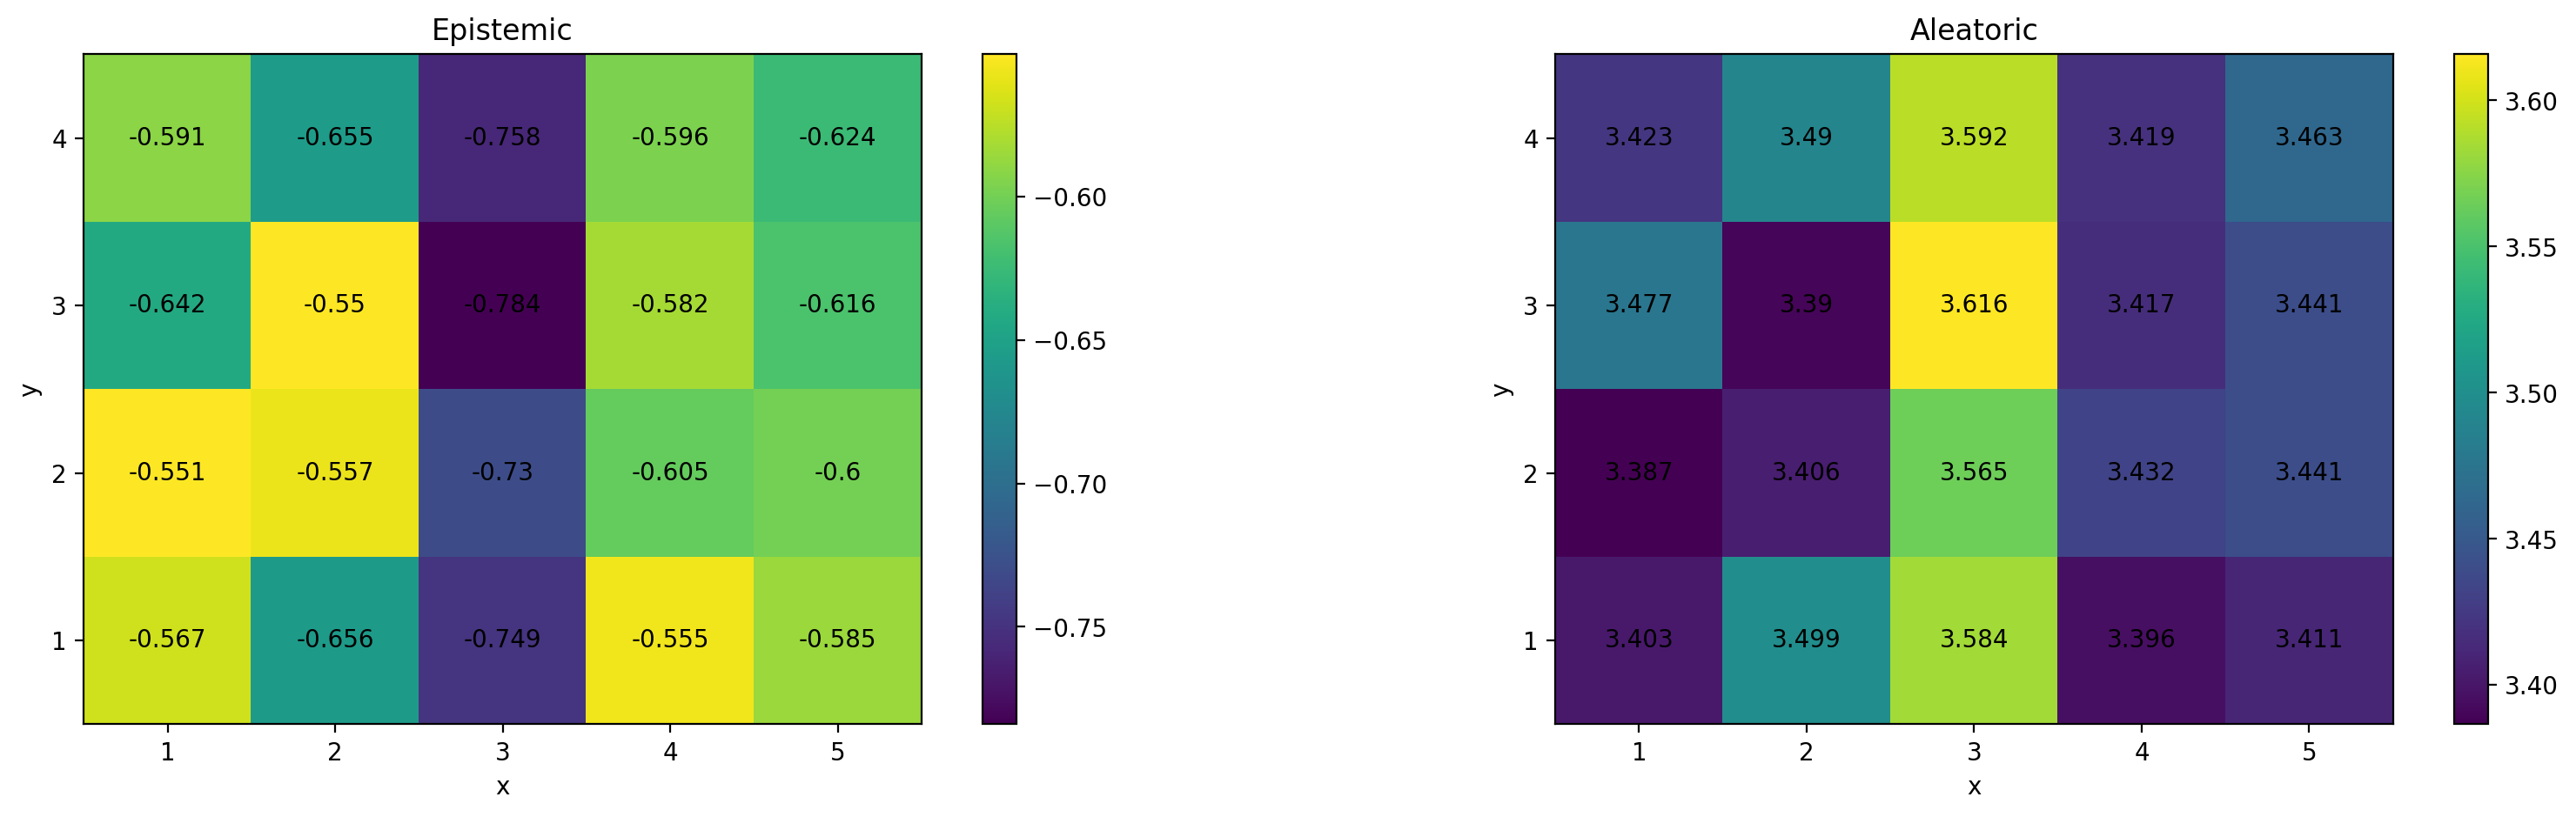

In [53]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_advi, 
                                                N, N2, L, 'UQ_Ladvi.png')

In [54]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_advi.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_advi.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

17162.779

### Non-identifiable ADVI

#### Prior-Posterior Overlap

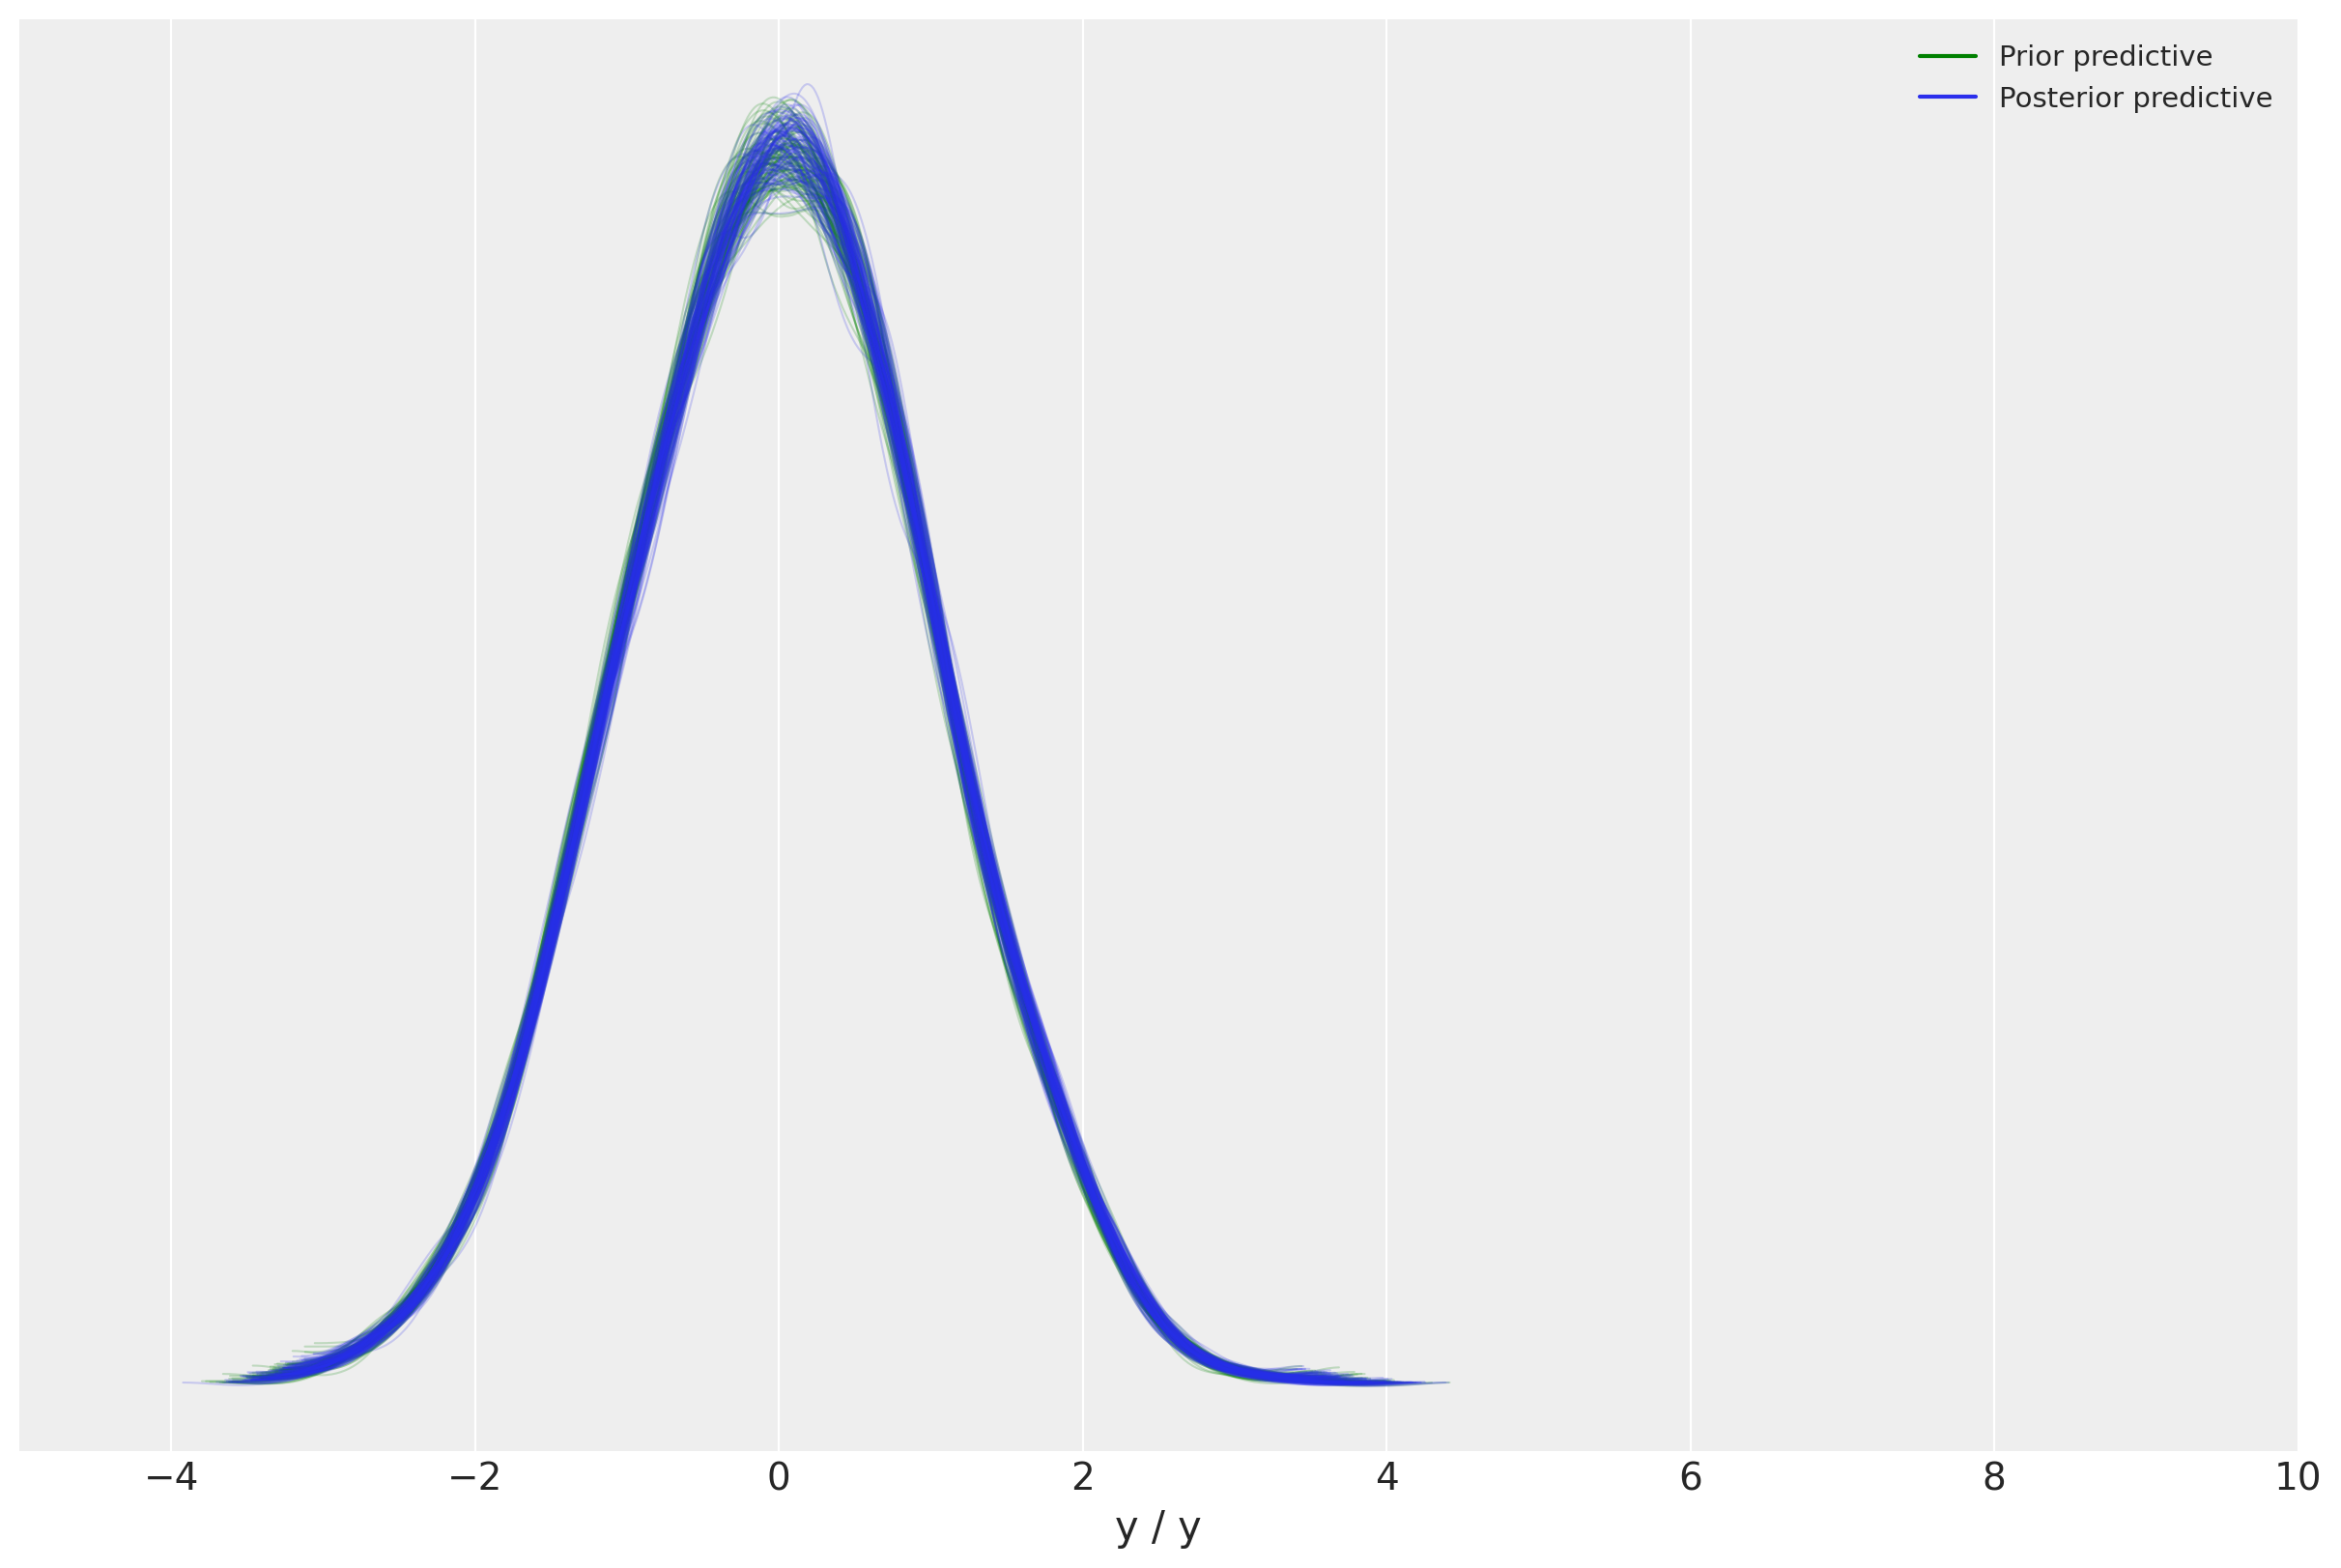

In [18]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_advin, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_advin, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Ladvi_uni.png', dpi=300)
plt.show()

In [19]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_advin.observed_data 
priorpredictive_dataset = idata_advin.prior_predictive 
postpredictive_dataset = idata_advin.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

In [20]:
# calculating the PPO using the PPO algorithm

PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [14:44<00:00,  8.84s/it]


0.9952197121401752

#### Uncertainty Quantification

In [21]:
post_advin.shape

(30000, 1, 582)

In [22]:
#thinning by factor of 12
post_advin = post_advin[::12, :]
post_advin.shape

(2500, 1, 582)

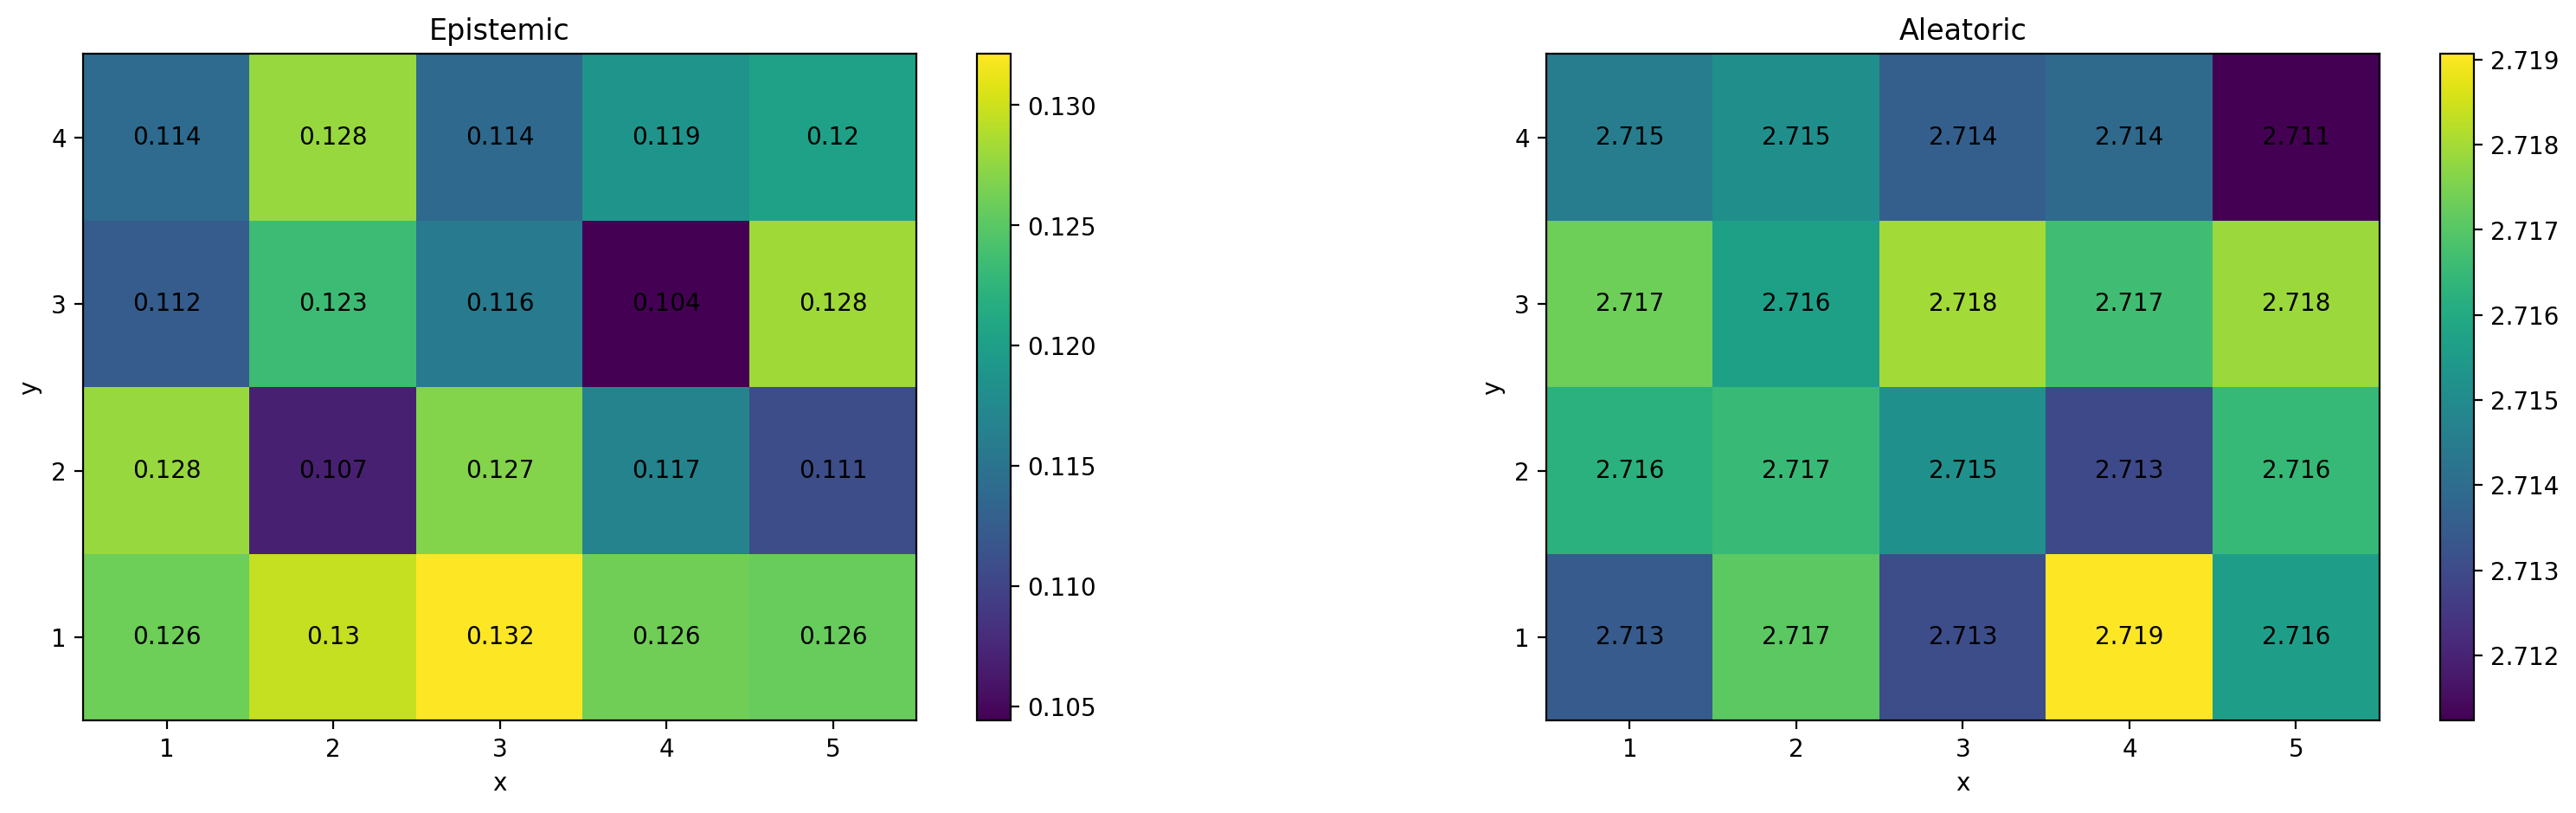

In [23]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_advin, 
                                                N, N2, L, 'UQ_Ladvi_uni.png')

In [24]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_advin.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_advin.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

226546.667

## Method 5: Stein Variational Gradient Descent (SVGD)

### Identifiable SVGD

#### Prior-Posterior Overlap

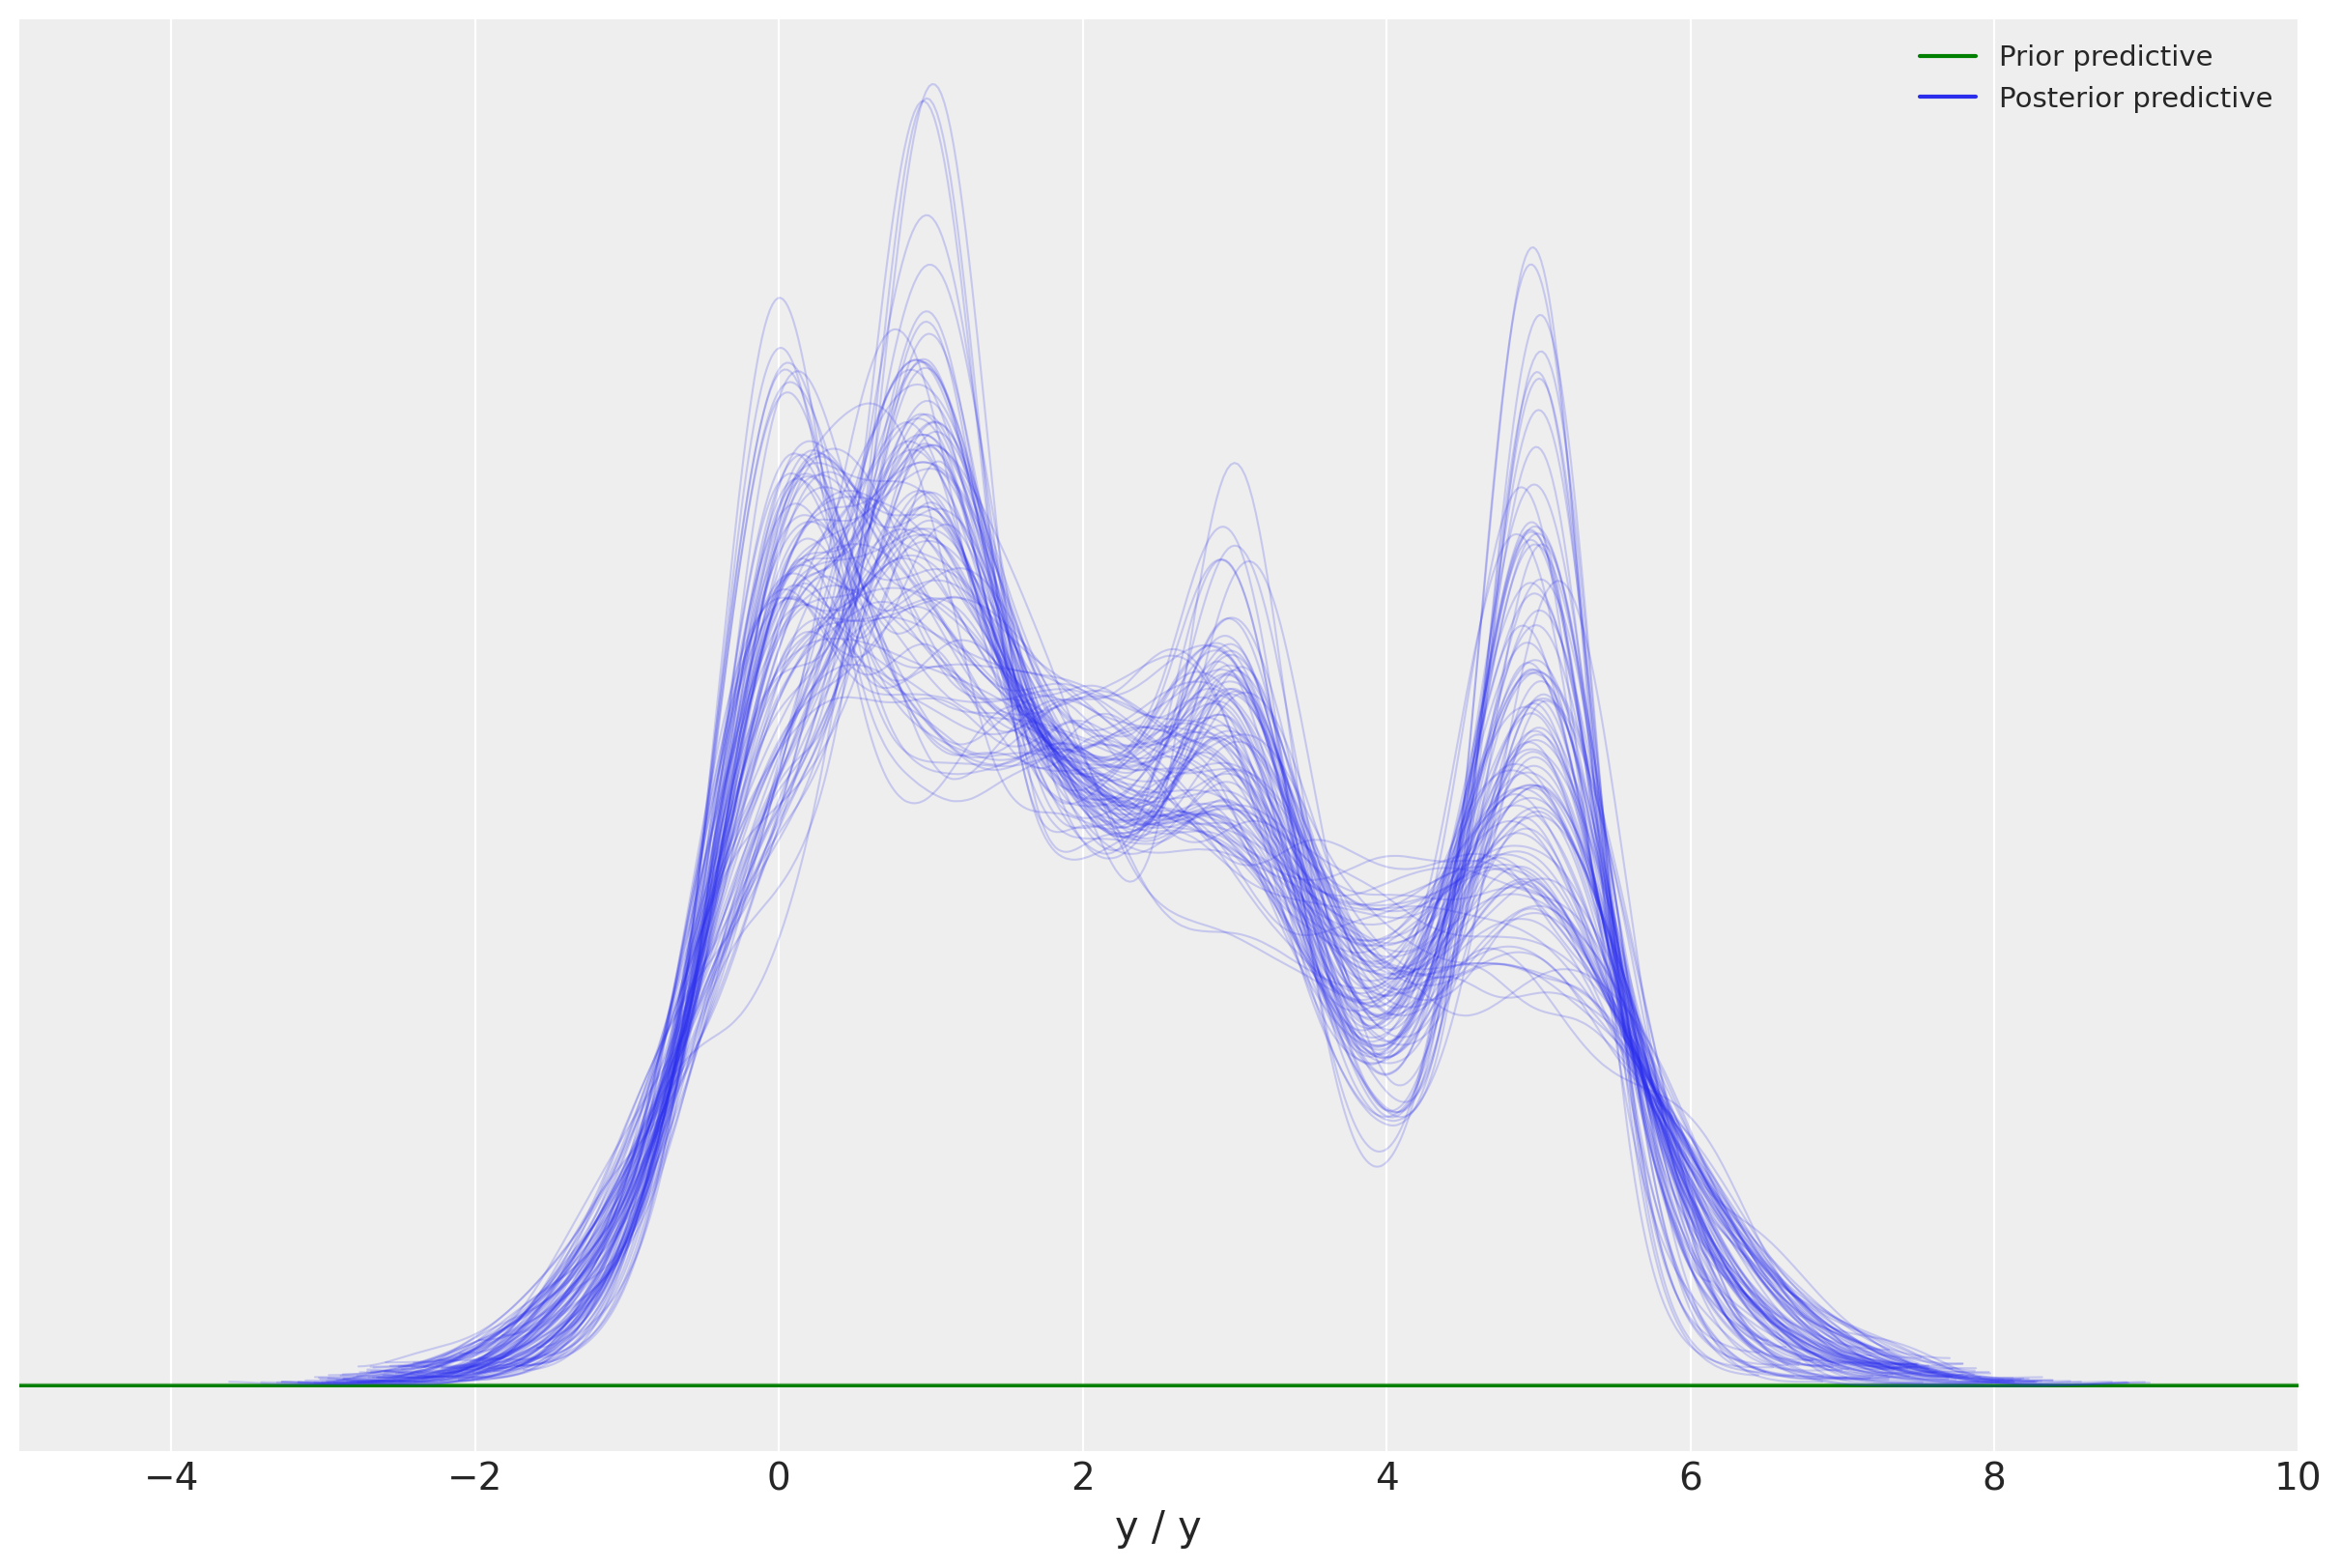

In [62]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_svgd, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_svgd, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lsvgd.png', dpi=300)
plt.show()

In [63]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_svgd.observed_data #change idata to ADVI specific name
priorpredictive_dataset = idata_svgd.prior_predictive 
postpredictive_dataset = idata_svgd.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


0.04609325771896661

#### Uncertainty Quantification

In [64]:
post_svgd.shape

(1000, 1, 582)

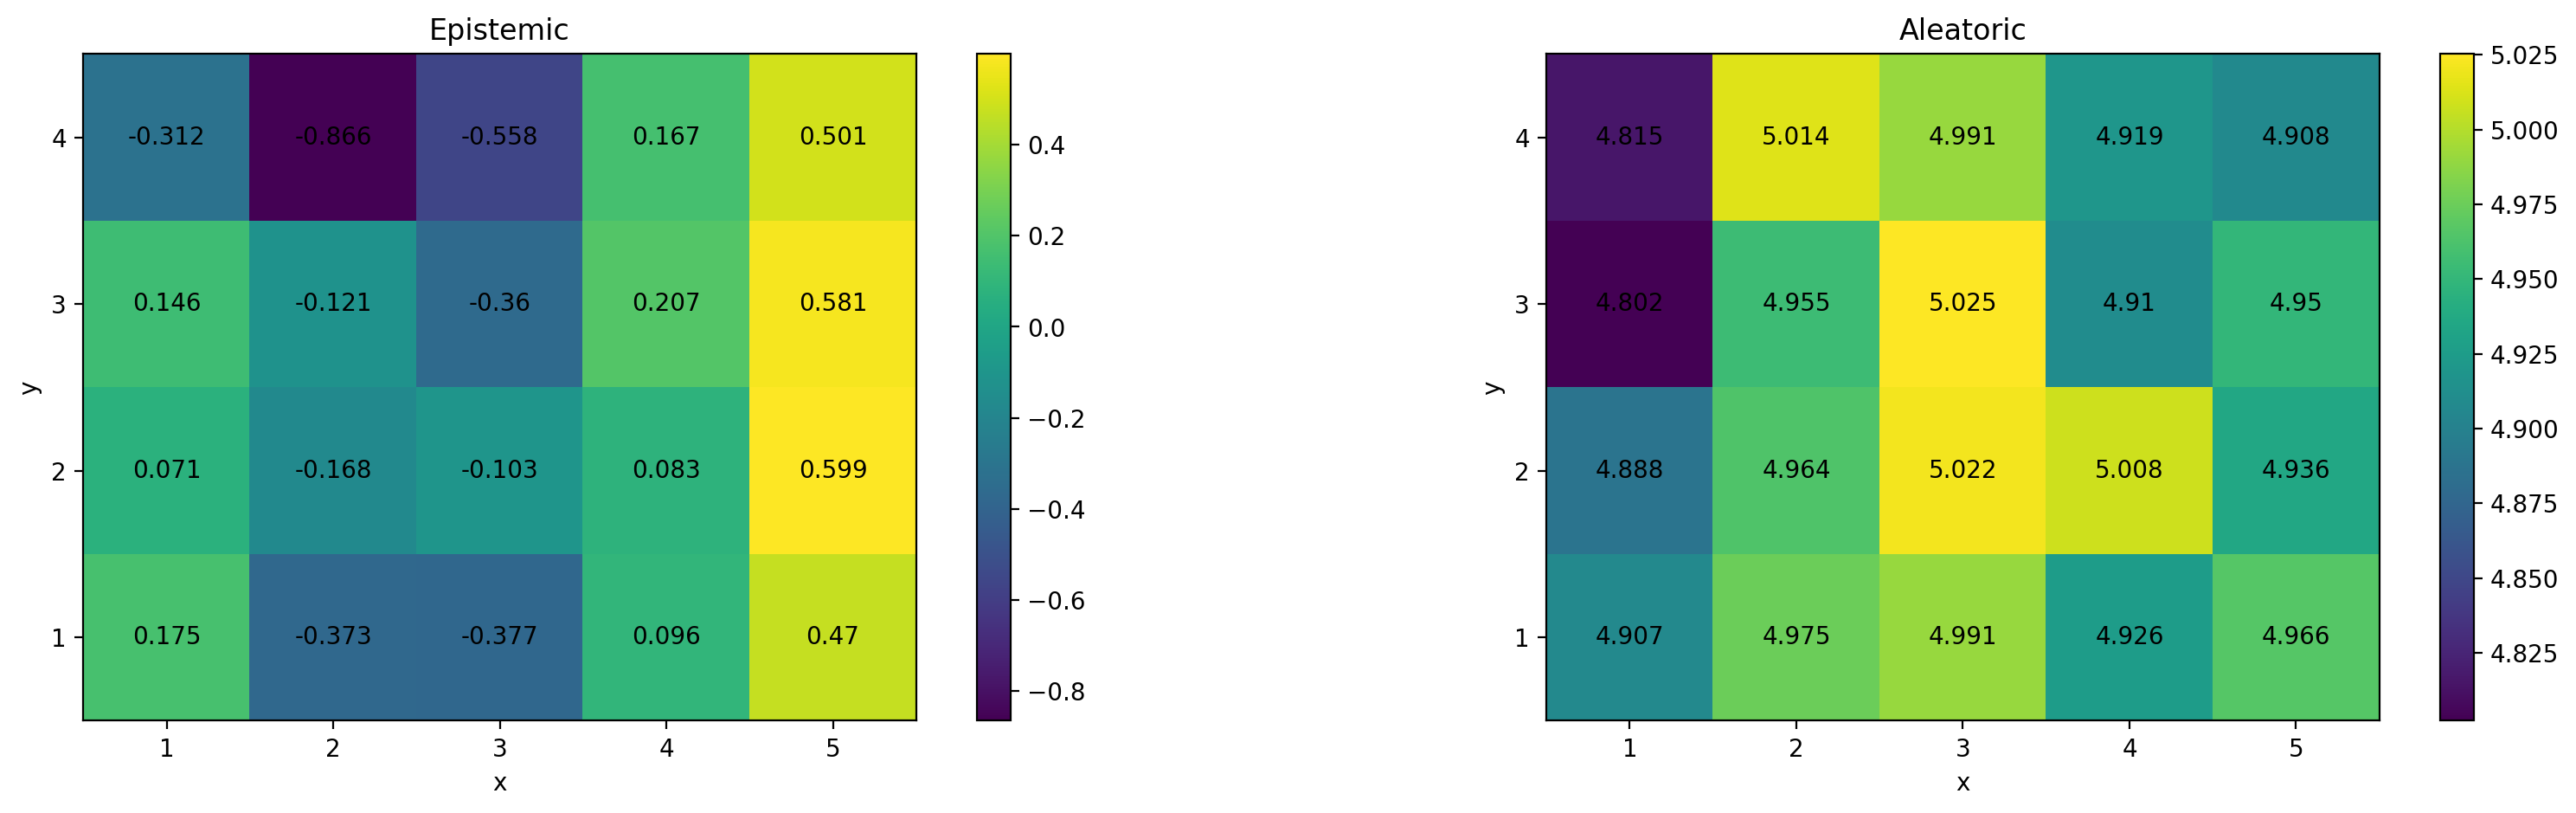

In [66]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_svgd, 
                                                N, N2, L, 'UQ_Lsvgd.png')

In [67]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_svgd.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_svgd.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

7395.11

### Non-identifiable SVGD

#### Prior-Posterior Overlap

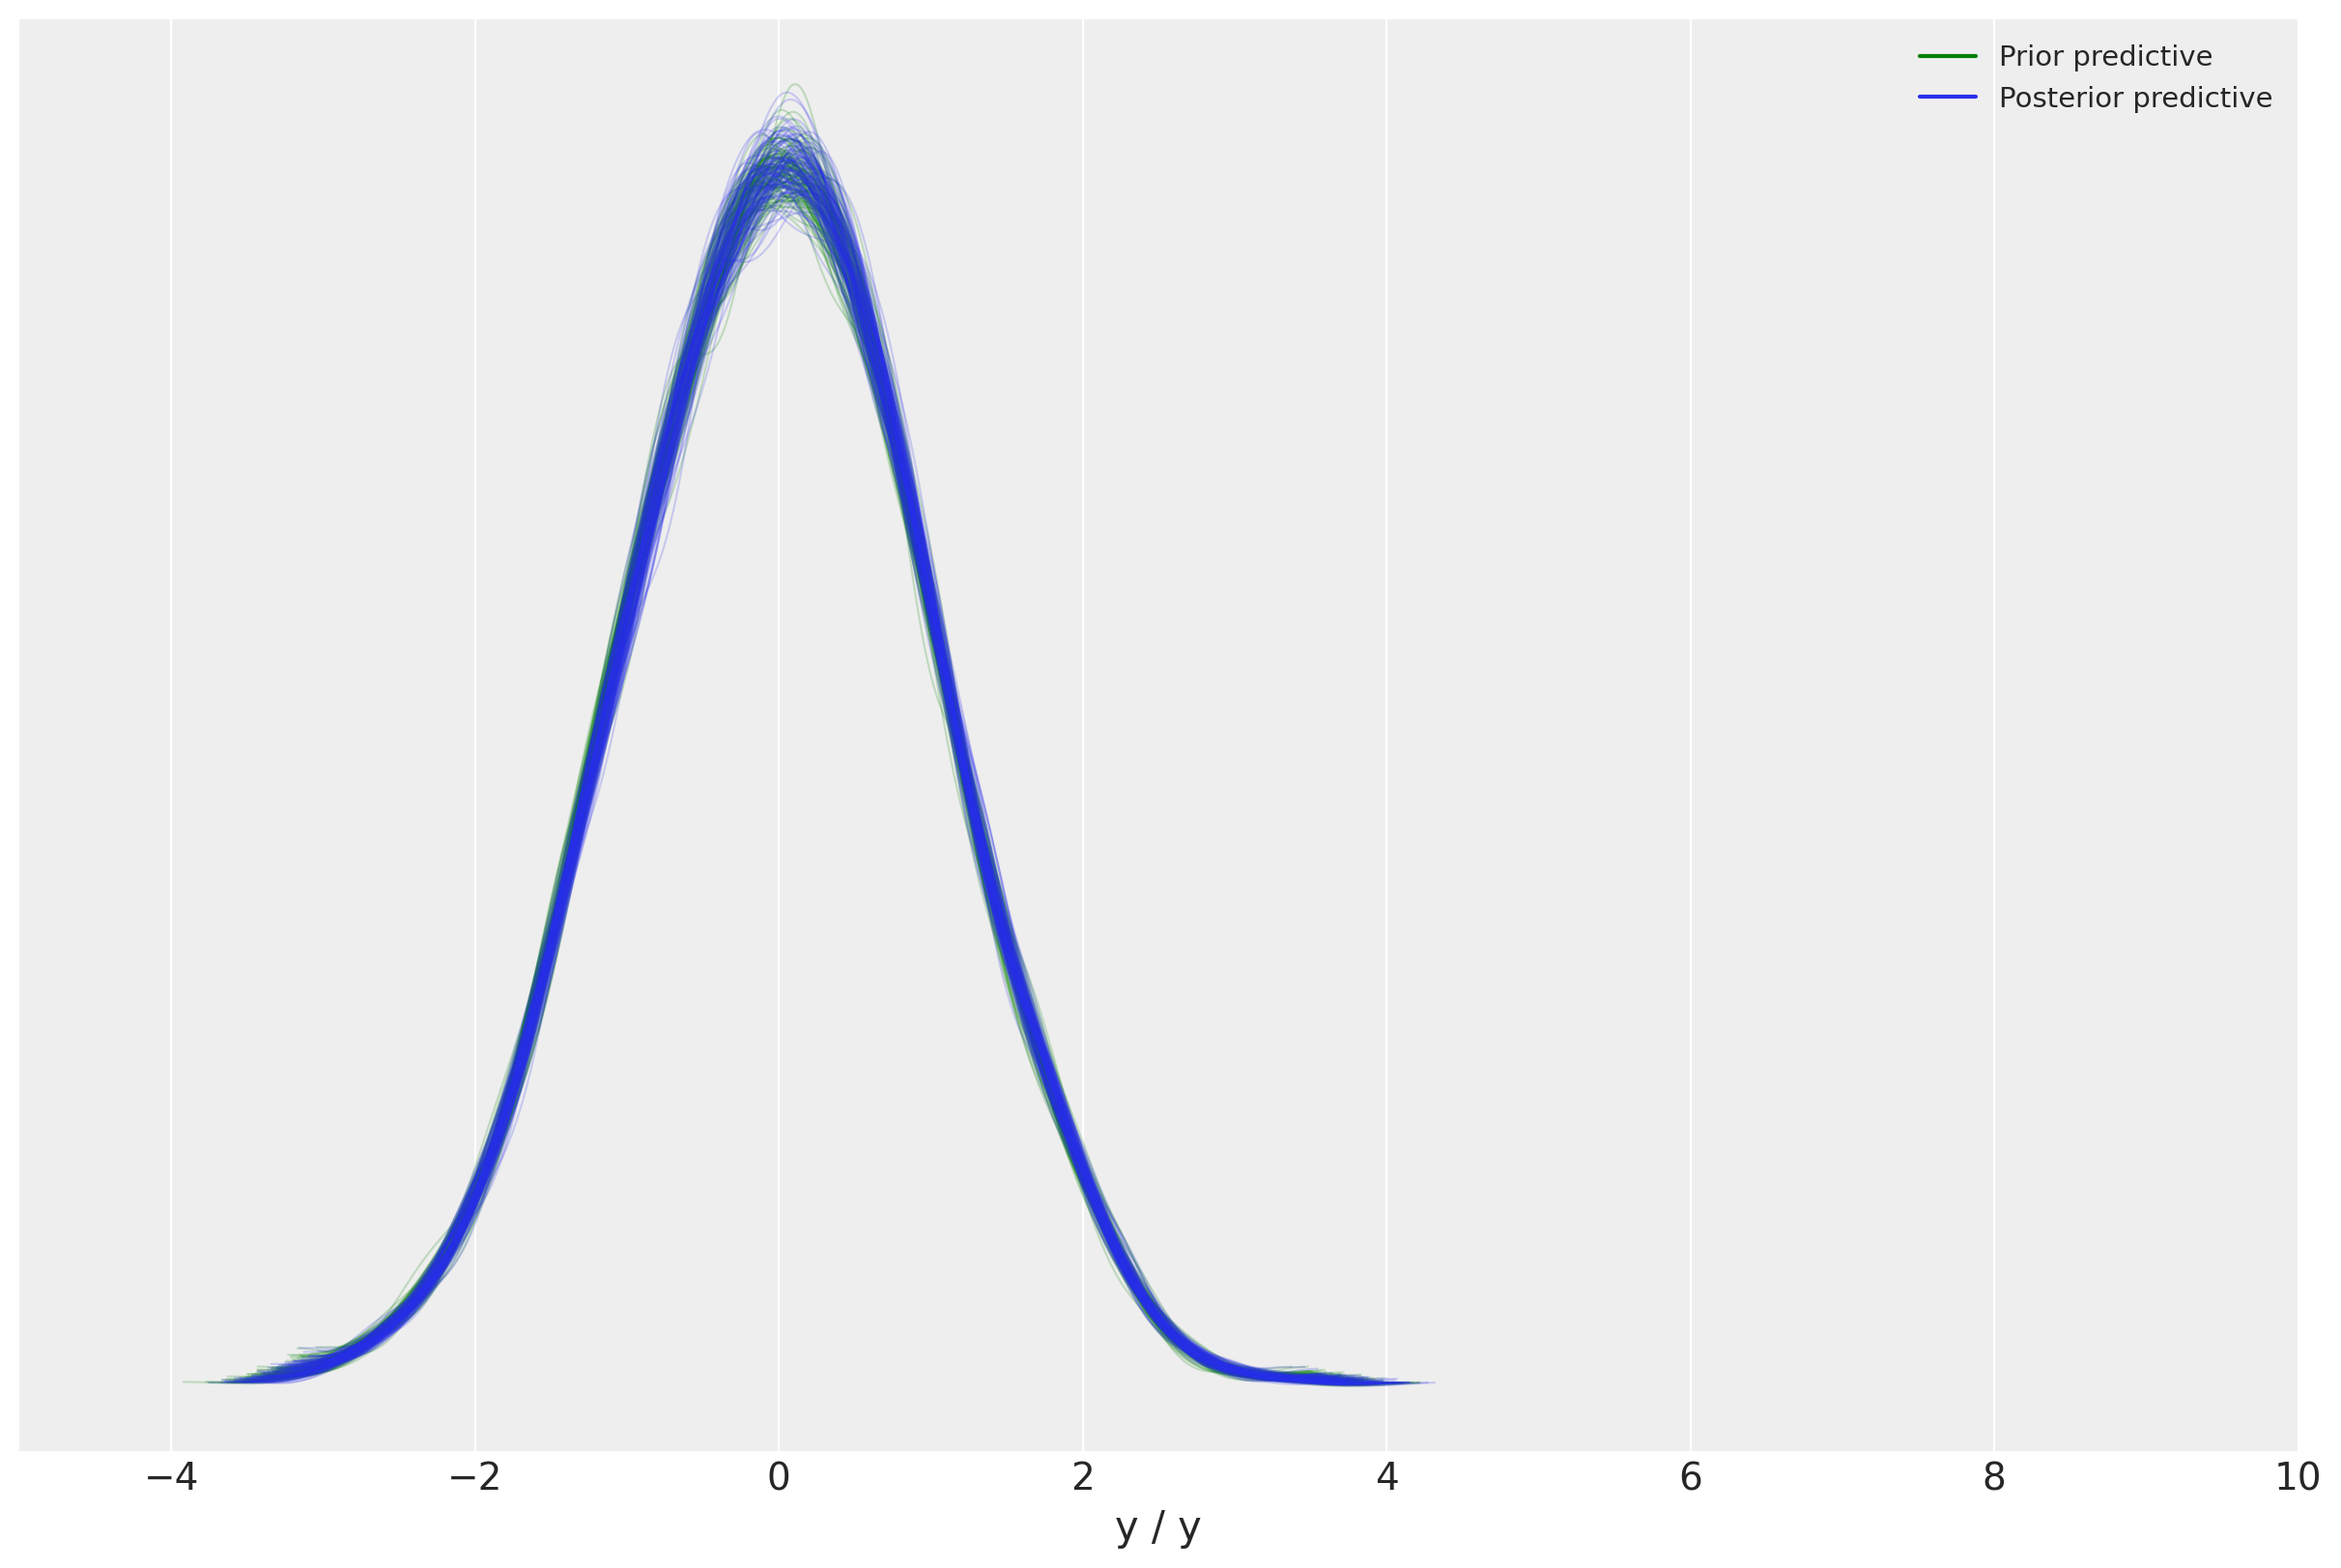

In [25]:
# Plotting the PPO

az.style.use("arviz-darkgrid")

fig, ax = plt.subplots(figsize=(12,8))
az.plot_ppc(idata_svgdn, mean=False, observed=False, num_pp_samples=100, group='prior', colors=['green', 'green', 'green'], ax=ax)
az.plot_ppc(idata_svgdn, mean=False, observed=False, num_pp_samples=100, group='posterior', ax=ax)
plt.xlim(-5, 10)
plt.savefig('PPO_Lsvgd_uni.png', dpi=300)
plt.show()

In [26]:
# calculation of PPO (approximation)

#get necessary data
observed_data = idata_svgdn.observed_data #change idata to ADVI specific name
priorpredictive_dataset = idata_svgdn.prior_predictive 
postpredictive_dataset = idata_svgdn.posterior_predictive

# flatten the data in such a way that it becomes an array
coords = {}

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
    
prior_xarray = priorpredictive_dataset.isel(coords)
post_xarray = postpredictive_dataset.isel(coords)
prior_array = prior_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))
post_array = post_xarray['y'].stack(z=('chain', 'draw', 'y_dim_0', 'y_dim_1'))

# calculating the PPO using the PPO algorithm
PPO(prior_array, post_array, 100)

100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


0.9952155009451795

#### Uncertainty Quantification

In [27]:
post_svgdn.shape

(1000, 1, 582)

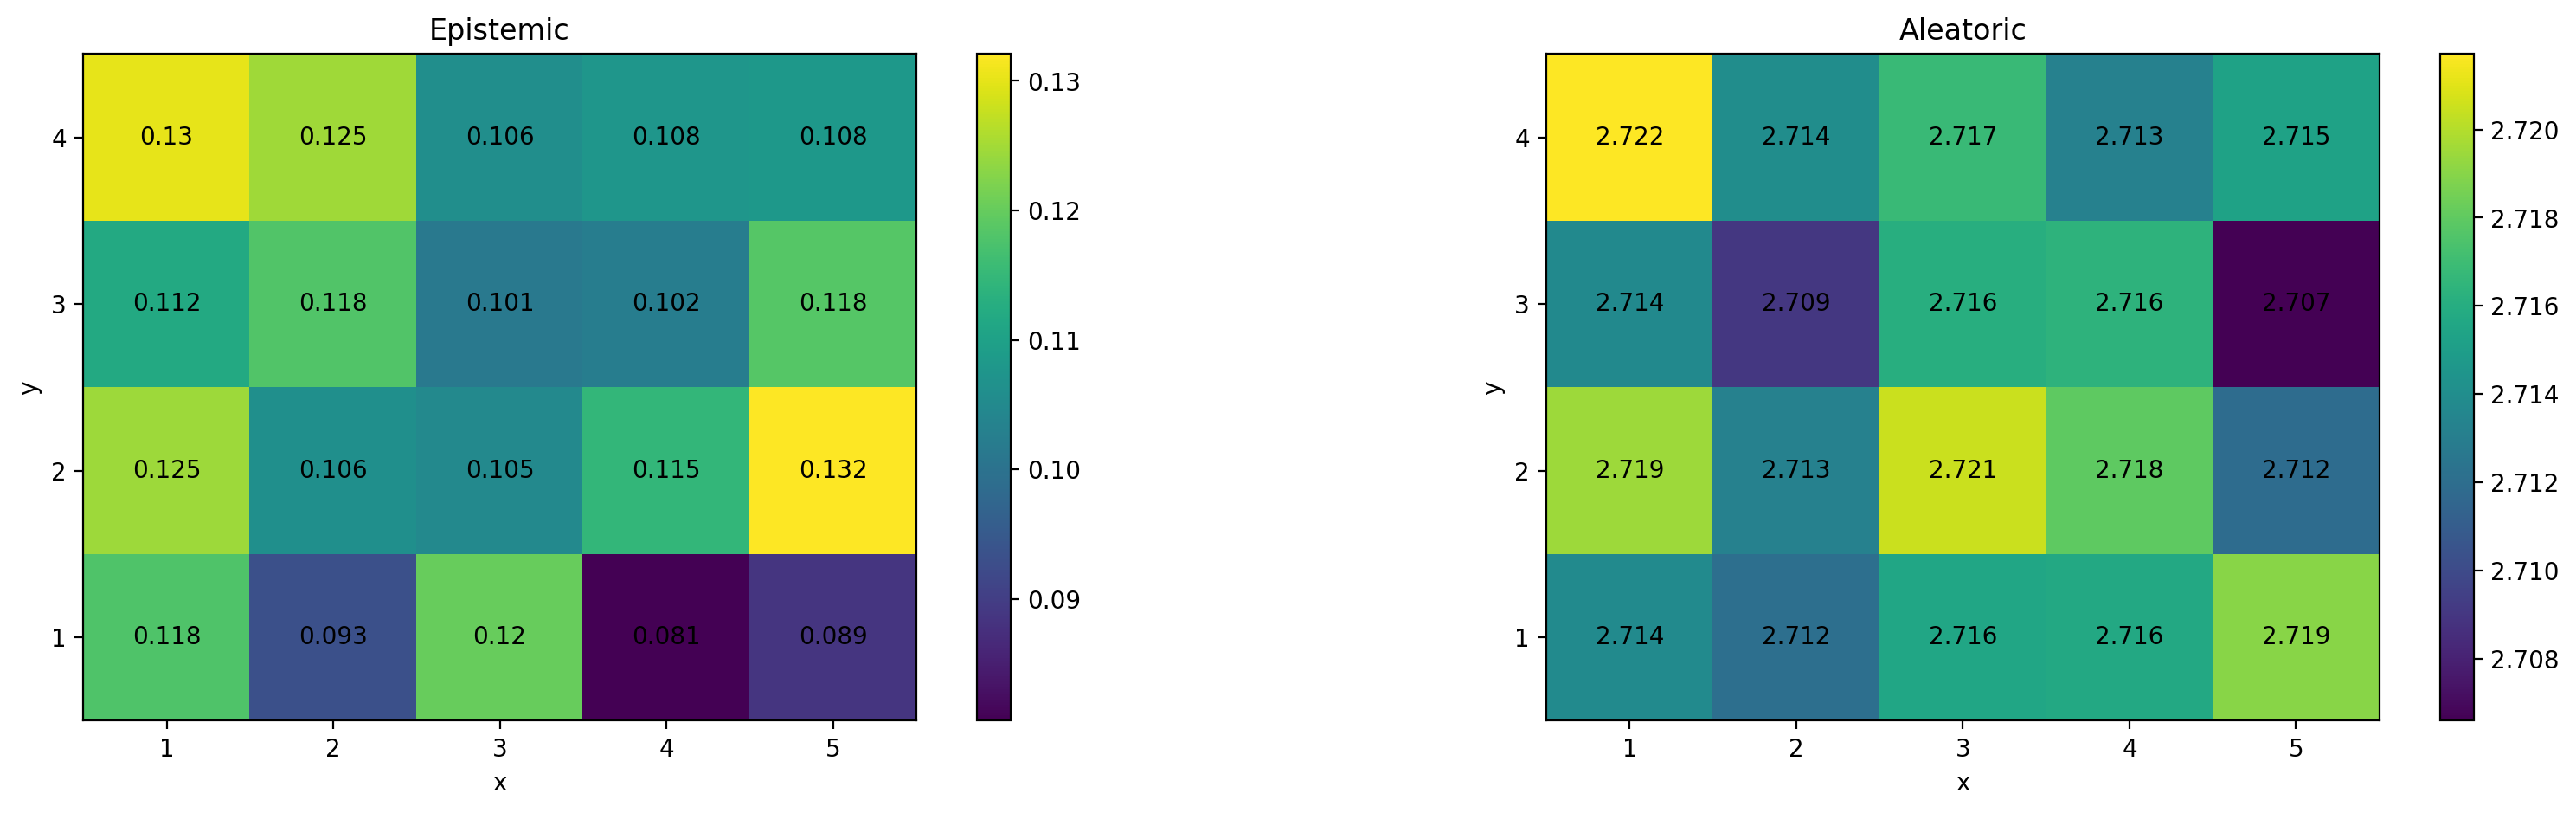

In [28]:
az.style.use("default")
N = 100 # number of 15 pt repeats
N2 = 30 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
lunar_decomp = lunar_entropy_decompose(bnn_lv_lunar, transitions, post_svgdn, 
                                                N, N2, L, 'UQ_Lsvgd_uni.png')

In [29]:
# calculating the negative log-likelihood as a quantitative performance measure of UQ (lower is better)

obs_logp = model_svgdn.y.logp
loglikelihood = np.array([obs_logp(p) for p in trace_svgdn.points()])
nll = -1 * loglikelihood
min_nll = min(nll)
round(min_nll, 3)

239513.565